# Probabilistic Machine Learning - Code

**Course:** Probabilistic Machine Learning (SoSe 2025)

**Lecturer:** Alvaro Diaz-Ruelas

**Student(s) Name(s):**  Niklas Nesseler, Lauren Pommer

**GitHub Username(s):**  @NiklasNesseler

**Date:**  20th of July 2025

**PROJECT-ID:** 21-1NNPLXX_EPL_match_results

---


In [7]:
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


## 2. Data Loading and Exploration

In [8]:
from google.colab import drive
drive.mount('/content/drive')
# Leave out if you run locally, we did the project in the google cloud environment

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df = pd.read_csv("/content/drive/MyDrive/Premier League Dataset/matches.csv")
# change to df = pd.read_csv("../data/matches.csv") if you run locally
df.head()

,Unnamed: 0,date,time,comp,round,day,venue,result,gf,ga,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,0,2020-09-21,20:15 (21:15),Premier League,Matchweek 2,Mon,Away,W,3,1,...,Match Report,NaN,13,8,21.1,2,1,1,2024,Manchester City
1,2,2020-09-27,16:30 (17:30),Premier League,Matchweek 3,Sun,Home,L,2,5,...,Match Report,NaN,16,5,19.8,1,0,0,2024,Manchester City
2,4,2020-10-03,17:30 (18:30),Premier League,Matchweek 4,Sat,Away,D,1,1,...,Match Report,NaN,23,1,18.2,1,0,0,2024,Manchester City
3,5,2020-10-17,17:30 (18:30),Premier League,Matchweek 5,Sat,Home,W,1,0,...,Match Report,NaN,13,5,17.7,0,0,0,2024,Manchester City
4,7,2020-10-24,12:30 (13:30),Premier League,Matchweek 6,Sat,Away,D,1,1,...,Match Report,NaN,14,7,20.9,1,0,0,2024,Manchester City


In [10]:
print("Dataset Info:")
print(df.info())
print(f"\nRows before filtering: {len(df)}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4788 entries, 0 to 4787
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    4788 non-null   int64  
 1   date          4788 non-null   object 
 2   time          4788 non-null   object 
 3   comp          4788 non-null   object 
 4   round         4788 non-null   object 
 5   day           4788 non-null   object 
 6   venue         4788 non-null   object 
 7   result        4788 non-null   object 
 8   gf            4788 non-null   int64  
 9   ga            4788 non-null   int64  
 10  opponent      4788 non-null   object 
 11  xg            4788 non-null   float64
 12  xga           4788 non-null   float64
 13  poss          4788 non-null   int64  
 14  attendance    3155 non-null   float64
 15  captain       4788 non-null   object 
 16  formation     4788 non-null   object 
 17  referee       4788 non-null   object 
 18  match report  

## 3. Data Preprocessing


In [11]:
df['date'] = pd.to_datetime(df['date'])
cutoff_date = pd.to_datetime('2022-08-01')

df_filtered = df[df['date'] >= cutoff_date].copy()

In [12]:
print(f"Number Rows before: {len(df_filtered)}")
print(f"Deleted Rows: {len(df) - len(df_filtered)}")

print(f"\nData after filtering:")
print(f"From: {df_filtered['date'].min()}")
print(f"To: {df_filtered['date'].max()}")

Number Rows before: 1520
Deleted Rows: 3268

Data after filtering:
From: 2022-08-05 00:00:00
To: 2024-05-19 00:00:00


In [13]:
df_filtered.shape

(1520, 28)

In [14]:
df_filtered.dtypes

,0
Unnamed: 0,int64
date,datetime64[ns]
time,object
comp,object
round,object
day,object
venue,object
result,object
gf,int64
ga,int64


In [15]:
df_filtered.to_csv('/content/drive/MyDrive/Premier League Dataset/dataset_after_cutoff_filtered.csv', index=False)
# change to df_filtered.to_csv("../data/dataset_after_cutoff_filtered") if you run locally

### Match Outcome Encoding
* Original results (W/D/L) were encoded as:

* Win = +1, Draw = 0, Loss = −1

* Purpose: Enables classification models (e.g., SVM, XGBoost) and maintains class balance (591 wins, 591 losses).



In [16]:
df_filtered['result'] = df_filtered['result'].map({
    'W': 1,   # Win = 1
    'D': 0,   # Draw = 0
    'L': -1   # Loss = -1
})

In [17]:
print("Distribution of Results after transformation:")
print(df_filtered['result'].value_counts().sort_index())

Distribution of Results after transformation:
result
-1    591
 0    338
 1    591
Name: count, dtype: int64


### De-duplication & Match-Based Restructuring
* The dataset is team-centric and contained duplicates.

* Transformed into a match-based structure, sorted by date.

* Duplicates were removed to ensure clean, non-redundant records.

In [18]:
if df_filtered['result'].isna().any():
    print(f"\nWarning: {df_filtered['result'].isna().sum()} NaN-Results found!")
    print("Data that could not get mapped:")

    print(df[df['date'] >= cutoff_date]['result'].value_counts())
else:
    print("\nAll Results transformed")


All Results transformed


In [19]:
print(f"\nExample:")
df_filtered[['date', 'team', 'opponent', 'result', 'gf', 'ga']].head(10)


Example:


,date,team,opponent,result,gf,ga
988,2023-08-11,Manchester City,Burnley,1,3,0
989,2023-08-19,Manchester City,Newcastle Utd,1,1,0
990,2023-08-27,Manchester City,Sheffield Utd,1,2,1
991,2023-09-02,Manchester City,Fulham,1,5,1
992,2023-09-16,Manchester City,West Ham,1,3,1
993,2023-09-23,Manchester City,Nott'ham Forest,1,2,0
994,2023-09-30,Manchester City,Wolves,-1,1,2
995,2023-10-08,Manchester City,Arsenal,-1,0,1
996,2023-10-21,Manchester City,Brighton,1,2,1
997,2023-10-29,Manchester City,Manchester Utd,1,3,0


In [20]:
df_filtered.head()

,Unnamed: 0,date,time,comp,round,day,venue,result,gf,ga,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
988,1,2023-08-11,20:00 (22:00),Premier League,Matchweek 1,Fri,Away,1,3,0,...,Match Report,NaN,17,8,13.9,0,0,0,2024,Manchester City
989,3,2023-08-19,20:00 (22:00),Premier League,Matchweek 2,Sat,Home,1,1,0,...,Match Report,NaN,14,4,17.9,0,0,0,2024,Manchester City
990,4,2023-08-27,14:00 (16:00),Premier League,Matchweek 3,Sun,Away,1,2,1,...,Match Report,NaN,29,9,17.3,2,0,1,2024,Manchester City
991,5,2023-09-02,15:00 (17:00),Premier League,Matchweek 4,Sat,Home,1,5,1,...,Match Report,NaN,6,4,14.8,0,1,1,2024,Manchester City
992,6,2023-09-16,15:00 (17:00),Premier League,Matchweek 5,Sat,Away,1,3,1,...,Match Report,NaN,29,13,16.4,1,0,0,2024,Manchester City


In [21]:
df_filtered['venue'] = df_filtered['venue'].map({
    'Home': 1,   # Home = 1
    'Away': 0    # Away = 0
})

In [22]:
if df_filtered['venue'].isna().any():
    print(f"\nWarnung: {df_filtered['venue'].isna().sum()} NaN values found")
else:
    print("\nVenue transformed")


Venue transformed


In [23]:
print(df_filtered[['date', 'team', 'opponent', 'venue', 'result', 'gf', 'ga']].head(10))

          date             team         opponent  venue  result  gf  ga
988 2023-08-11  Manchester City          Burnley      0       1   3   0
989 2023-08-19  Manchester City    Newcastle Utd      1       1   1   0
990 2023-08-27  Manchester City    Sheffield Utd      0       1   2   1
991 2023-09-02  Manchester City           Fulham      1       1   5   1
992 2023-09-16  Manchester City         West Ham      0       1   3   1
993 2023-09-23  Manchester City  Nott'ham Forest      1       1   2   0
994 2023-09-30  Manchester City           Wolves      0      -1   1   2
995 2023-10-08  Manchester City          Arsenal      0      -1   0   1
996 2023-10-21  Manchester City         Brighton      1       1   2   1
997 2023-10-29  Manchester City   Manchester Utd      0       1   3   0


In [24]:
print(f"\nHome vs Away-Performance:")
home_away_stats = df_filtered.groupby('venue')['result'].agg(['count', 'mean'])
home_away_stats.columns = ['amount_games', 'average_result']
print(home_away_stats)


Home vs Away-Performance:
       amount_games  average_result
venue                              
0               760       -0.167105
1               760        0.167105


In [25]:
df_filtered = df_filtered.sort_values(['date', 'time']).reset_index(drop=True)

In [26]:
home_games = df_filtered[df_filtered['venue'] == 1].copy()

In [27]:
away_games = df_filtered[df_filtered['venue'] == 0].copy()

In [28]:
away_games_flipped = away_games.copy()
away_games_flipped['home_team'] = away_games['opponent']
away_games_flipped['away_team'] = away_games['team']

In [29]:
home_games['home_team'] = home_games['team']
home_games['away_team'] = home_games['opponent']

In [30]:
home_games['home_goals'] = home_games['gf']
home_games['away_goals'] = home_games['ga']
home_games['home_xg'] = home_games['xg']
home_games['away_xg'] = home_games['xga']
home_games['home_poss'] = home_games['poss']
home_games['home_shots'] = home_games['sh']
home_games['home_sot'] = home_games['sot']

In [31]:
away_games_flipped['home_goals'] = away_games['ga']
away_games_flipped['away_goals'] = away_games['gf']
away_games_flipped['home_xg'] = away_games['xga']
away_games_flipped['away_xg'] = away_games['xg']
away_games_flipped['home_poss'] = 100 - away_games['poss']
away_games_flipped['home_shots'] = None
away_games_flipped['home_sot'] = None

In [32]:
matches = pd.merge(
    home_games[['date', 'time', 'home_team', 'away_team', 'home_goals', 'away_goals',
                'home_xg', 'away_xg', 'home_poss', 'comp', 'round', 'day', 'referee', 'season']],
    away_games_flipped[['date', 'time', 'home_team', 'away_team']],
    on=['date', 'time', 'home_team', 'away_team'],
    how='left'
)

In [33]:
matches['result'] = matches.apply(lambda row:
    1 if row['home_goals'] > row['away_goals'] else
    0 if row['home_goals'] == row['away_goals'] else -1, axis=1)


In [34]:
matches = matches.sort_values(['date', 'time']).reset_index(drop=True)

In [35]:
print(f"Original Dataset: {len(df_filtered)} Rows")
print(f"Match-based Dataset: {len(matches)} Rows")
print(f"\nFirst 5 Matches:")
print(matches[['date', 'time', 'home_team', 'away_team', 'home_goals', 'away_goals', 'result']].head())

Original Dataset: 1520 Rows
Match-based Dataset: 760 Rows

First 5 Matches:
        date           time          home_team        away_team  home_goals  \
0 2022-08-05  20:00 (21:00)     Crystal Palace          Arsenal           0   
1 2022-08-06  12:30 (13:30)             Fulham        Liverpool           2   
2 2022-08-06  15:00 (16:00)   Newcastle United  Nott'ham Forest           2   
3 2022-08-06  15:00 (16:00)  Tottenham Hotspur      Southampton           4   
4 2022-08-06  15:00 (16:00)        Bournemouth      Aston Villa           2   

   away_goals  result  
0           2      -1  
1           2       0  
2           0       1  
3           1       1  
4           0       1  


## 4. Feature Engineering

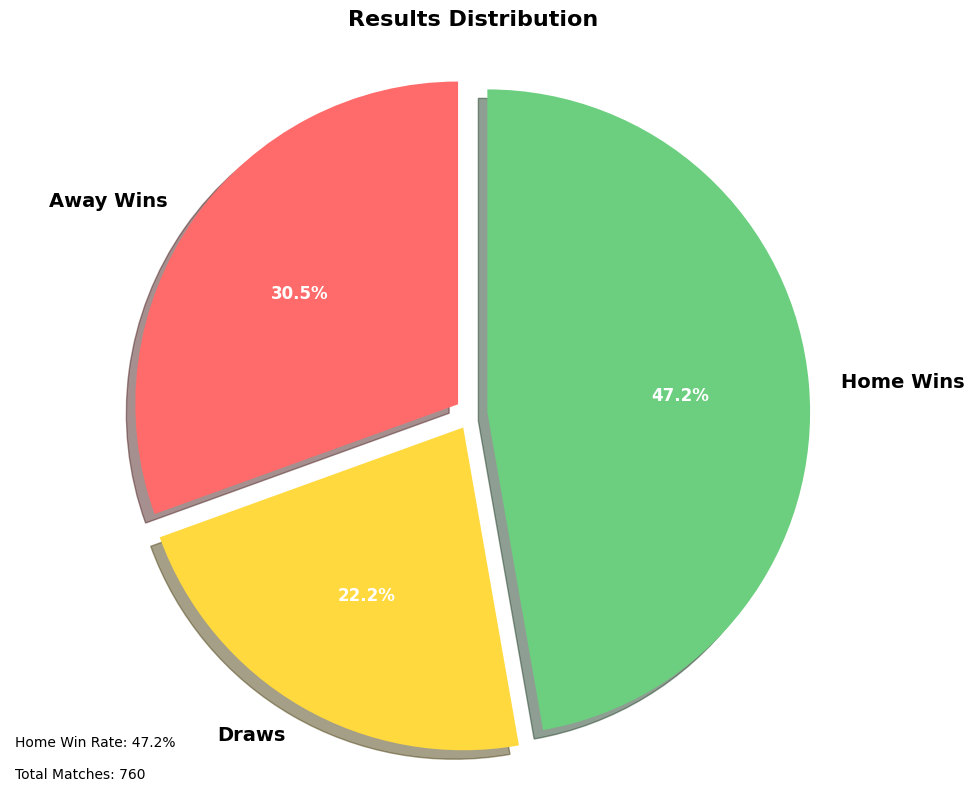

Detailed Statistics:
Total Matches: 760
Home Wins: 359 (47.2%)
Draws: 169 (22.2%)
Away Wins: 232 (30.5%)


In [36]:
import matplotlib.pyplot as plt


result_counts = matches['result'].value_counts().sort_index()

labels = ['Away Wins', 'Draws', 'Home Wins']
colors = ['#ff6b6b', '#ffd93d', '#6bcf7f']
explode = (0.05, 0.05, 0.05)

plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(result_counts.values,
                                   labels=labels,
                                   colors=colors,
                                   autopct='%1.1f%%',
                                   explode=explode,
                                   shadow=True,
                                   startangle=90)


for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_weight('bold')

for text in texts:
    text.set_fontsize(14)
    text.set_weight('bold')

plt.title('Results Distribution',
          fontsize=16, fontweight='bold', pad=20)
total_matches = len(matches)
home_win_rate = (result_counts[1] / total_matches) * 100
draw_rate = (result_counts[0] / total_matches) * 100
away_win_rate = (result_counts[-1] / total_matches) * 100

plt.figtext(0.02, 0.02, f'Total Matches: {total_matches}', fontsize=10)
plt.figtext(0.02, 0.06, f'Home Win Rate: {home_win_rate:.1f}%', fontsize=10)

plt.axis('equal')
plt.tight_layout()
plt.show()


print(f"Detailed Statistics:")
print(f"Total Matches: {total_matches}")
print(f"Home Wins: {result_counts[1]} ({home_win_rate:.1f}%)")
print(f"Draws: {result_counts[0]} ({draw_rate:.1f}%)")
print(f"Away Wins: {result_counts[-1]} ({away_win_rate:.1f}%)")

* Recent Form (Last 5 Matches)

  * Calculated as average points from last 5 games (Win=3, Draw=1, Loss=0)

  * Feature: form_last_5_avg

  * Reflects team momentum for better short-term prediction.

In [37]:

def calculate_form_average(df):

    df_sorted = df.sort_values(['team', 'date']).reset_index(drop=True)


    df_sorted['points'] = df_sorted['result'].map({1: 3, 0: 1, -1: 0})


    df_sorted['form_last_5_avg'] = df_sorted.groupby('team')['points'].transform(
        lambda x: x.rolling(window=5, min_periods=1).mean()
    )

    return df_sorted


df_with_form = calculate_form_average(df_filtered)


print("Example Form Statistics")
sample_team = df_with_form[df_with_form['team'] == 'Manchester City'].tail(10)
print(sample_team[['date', 'team', 'opponent', 'venue', 'result', 'points', 'form_last_5_avg']])

# Statistiken zur Form
print(f"\nForm-Statistics (Points per Game):")
print(f"Mean Form (all Teams): {df_with_form['form_last_5_avg'].mean():.2f}")
print(f"Best possible Form (5 Wins): 3.0 Points/Game")
print(f"Worst possible Form (5 Niederlagen): 0.0 Points/Game")
print(f"Neutral Form (50% Wins, 50% Losses): 1.5 Points/Game")

# Top Teams nach aktueller Form (letzte 5 Spiele)
print(f"\nTeams with the best current Form:")
latest_form = df_with_form.groupby('team').tail(1)[['team', 'form_last_5_avg']].sort_values('form_last_5_avg', ascending=False)
print(latest_form.head(10))

# Verteilung der Form-Werte
print(f"\nForm-Distribution:")
print(f"Amount of Teams > 2.0 Points/Game: {(latest_form['form_last_5_avg'] > 2.0).sum()}")
print(f"Amount of Teams < 1.0 Points/Game: {(latest_form['form_last_5_avg'] < 1.0).sum()}")

Example Form Statistics
          date             team         opponent  venue  result  points  \
978 2024-03-31  Manchester City          Arsenal      1       0       1   
979 2024-04-03  Manchester City      Aston Villa      1       1       3   
980 2024-04-06  Manchester City   Crystal Palace      0       1       3   
981 2024-04-13  Manchester City       Luton Town      1       1       3   
982 2024-04-25  Manchester City         Brighton      0       1       3   
983 2024-04-28  Manchester City  Nott'ham Forest      0       1       3   
984 2024-05-04  Manchester City           Wolves      1       1       3   
985 2024-05-11  Manchester City           Fulham      0       1       3   
986 2024-05-14  Manchester City        Tottenham      0       1       3   
987 2024-05-19  Manchester City         West Ham      1       1       3   

     form_last_5_avg  
978              2.2  
979              2.2  
980              2.2  
981              2.2  
982              2.6  
983         

In [38]:
df_with_form.head()

,Unnamed: 0,date,time,comp,round,day,venue,result,gf,ga,...,sh,sot,dist,fk,pk,pkatt,season,team,points,form_last_5_avg
0,0,2022-08-05,20:00 (21:00),Premier League,Matchweek 1,Fri,0,1,2,0,...,10,2,14.6,1,0,0,2023,Arsenal,3,3.0
1,1,2022-08-13,15:00 (16:00),Premier League,Matchweek 2,Sat,1,1,4,2,...,19,7,13.0,0,0,0,2023,Arsenal,3,3.0
2,2,2022-08-20,17:30 (18:30),Premier League,Matchweek 3,Sat,0,1,3,0,...,14,6,14.8,0,0,0,2023,Arsenal,3,3.0
3,3,2022-08-27,17:30 (18:30),Premier League,Matchweek 4,Sat,1,1,2,1,...,22,8,15.5,1,0,0,2023,Arsenal,3,3.0
4,4,2022-08-31,19:30 (20:30),Premier League,Matchweek 5,Wed,1,1,2,1,...,22,8,16.3,1,0,0,2023,Arsenal,3,3.0


In [39]:

def add_form_avg_to_matches(matches_df, form_df):
    matches_with_form = matches_df.copy()


    home_form = []
    away_form = []

    for idx, match in matches_df.iterrows():
        date = match['date']
        home_team = match['home_team']
        away_team = match['away_team']


        home_team_form = form_df[
            (form_df['team'] == home_team) &
            (form_df['date'] == date) &
            (form_df['venue'] == 1)
        ]['form_last_5_avg'].iloc[0] if len(form_df[
            (form_df['team'] == home_team) &
            (form_df['date'] == date) &
            (form_df['venue'] == 1)
        ]) > 0 else None


        away_team_form = form_df[
            (form_df['team'] == away_team) &
            (form_df['date'] == date) &
            (form_df['venue'] == 0)
        ]['form_last_5_avg'].iloc[0] if len(form_df[
            (form_df['team'] == away_team) &
            (form_df['date'] == date) &
            (form_df['venue'] == 0)
        ]) > 0 else None

        home_form.append(home_team_form)
        away_form.append(away_team_form)

    matches_with_form['home_team_form'] = home_form
    matches_with_form['away_team_form'] = away_form

    return matches_with_form


matches_with_form = add_form_avg_to_matches(matches, df_with_form)

print("Matches with Form Data (Mean):")
print(matches_with_form[['date', 'home_team', 'away_team', 'home_team_form', 'away_team_form', 'result']].head(10))

Matches with Form Data (Mean):
        date          home_team        away_team  home_team_form  \
0 2022-08-05     Crystal Palace          Arsenal             0.0   
1 2022-08-06             Fulham        Liverpool             1.0   
2 2022-08-06   Newcastle United  Nott'ham Forest             3.0   
3 2022-08-06  Tottenham Hotspur      Southampton             3.0   
4 2022-08-06        Bournemouth      Aston Villa             3.0   
5 2022-08-06       Leeds United           Wolves             3.0   
6 2022-08-06            Everton          Chelsea             0.0   
7 2022-08-07  Manchester United         Brighton             0.0   
8 2022-08-07     Leicester City        Brentford             1.0   
9 2022-08-07    West Ham United  Manchester City             0.0   

   away_team_form  result  
0             3.0      -1  
1             1.0       0  
2             NaN       1  
3             0.0       1  
4             0.0       1  
5             NaN       1  
6             3.0      -

In [40]:
matches_with_form['home_team_form'] = matches_with_form['home_team_form'].fillna(1.5)
matches_with_form['away_team_form'] = matches_with_form['away_team_form'].fillna(1.5)

In [41]:
print(f"NaN-Values in home_team_form: {matches_with_form['home_team_form'].isna().sum()}")
print(f"NaN-Values in away_team_form: {matches_with_form['away_team_form'].isna().sum()}")
print(f"Total Matches: {len(matches_with_form)}")

NaN-Values in home_team_form: 0
NaN-Values in away_team_form: 0
Total Matches: 760


In [42]:
import pandas as pd

def get_form_table_at_date(df_with_form, target_date):
    target_date = pd.to_datetime(target_date)

    # Alle Teams finden
    all_teams = df_with_form['team'].unique()

    form_table = []

    for team in all_teams:

        team_games = df_with_form[
            (df_with_form['team'] == team) &
            (df_with_form['date'] <= target_date)
        ].sort_values('date')

        if len(team_games) > 0:
            latest_game = team_games.iloc[-1]
            form_table.append({
                'Team': team,
                'Form_Last_5': latest_game['form_last_5_avg'],
                'Last_Game_Date': latest_game['date'],
                'Last_Result': latest_game['result'],
                'Last_Opponent': latest_game['opponent']
            })

    form_df = pd.DataFrame(form_table)
    form_df = form_df.sort_values('Form_Last_5', ascending=False).reset_index(drop=True)
    form_df['Rank'] = range(1, len(form_df) + 1)

    return form_df

target_date = '2023-12-24'
form_table = get_form_table_at_date(df_with_form, target_date)

print(f"Team-Form Ranking at {target_date}:")
print("=" * 60)
print(form_table.round(3))


print(f"\nTop 10 Teams in Form from {target_date}:")
print("=" * 50)
for idx, row in form_table.head(10).iterrows():
    print(f"{row['Rank']:2d}. {row['Team']:<20} - {row['Form_Last_5']:.2f} Punkte/Game")

print(f"\nWorst 5 teams by Form at {target_date}:")
print("=" * 50)
for idx, row in form_table.tail(5).iterrows():
    print(f"{row['Rank']:2d}. {row['Team']:<20} - {row['Form_Last_5']:.2f} Punkte/Game")

print(f"\nStatistics at {target_date}:")
print(f"Best Team: {form_table.iloc[0]['Team']} ({form_table.iloc[0]['Form_Last_5']:.2f})")
print(f"Worst Team: {form_table.iloc[-1]['Team']} ({form_table.iloc[-1]['Form_Last_5']:.2f})")
print(f"Mean Form: {form_table['Form_Last_5'].mean():.2f}")

Team-Form Ranking at 2023-12-24:
                        Team  Form_Last_5 Last_Game_Date  Last_Result  \
0                Bournemouth          2.6     2023-12-23            1   
1                    Everton          2.4     2023-12-23           -1   
2                Aston Villa          2.2     2023-12-22            0   
3                  Liverpool          2.2     2023-12-23            0   
4          Tottenham Hotspur          2.0     2023-12-23            1   
5            West Ham United          2.0     2023-12-23            1   
6                    Arsenal          2.0     2023-12-23            0   
7    Wolverhampton Wanderers          1.4     2023-12-24            1   
8                    Burnley          1.4     2023-12-23            1   
9                    Chelsea          1.2     2023-12-24           -1   
10           Manchester City          1.2     2023-12-16            0   
11          Newcastle United          1.2     2023-12-23           -1   
12                

In [43]:
dates_to_check = ['2023-12-24', '2024-01-01', '2024-05-15']

for date in dates_to_check:
    print(f"\n{'='*60}")
    print(f"TOP 5 TEAMS AM {date}:")
    print(f"{'='*60}")
    table = get_form_table_at_date(df_with_form, date)
    for idx, row in table.head(5).iterrows():
        print(f"{row['Rank']}. {row['Team']:<20} - {row['Form_Last_5']:.2f}")


TOP 5 TEAMS AM 2023-12-24:
1. Bournemouth          - 2.60
2. Everton              - 2.40
3. Aston Villa          - 2.20
4. Liverpool            - 2.20
5. Tottenham Hotspur    - 2.00

TOP 5 TEAMS AM 2024-01-01:
1. Bournemouth          - 2.40
2. West Ham United      - 2.40
3. Tottenham Hotspur    - 2.40
4. Liverpool            - 2.20
5. Manchester City      - 2.00

TOP 5 TEAMS AM 2024-05-15:
1. Arsenal              - 3.00
2. Manchester City      - 3.00
3. Chelsea              - 2.60
4. Crystal Palace       - 2.60
5. Everton              - 2.60


* Home vs Away Strength

  * Calculated average points per game separately for home and away matches:

  * home_strength and away_strength

  * Based on the venue column.

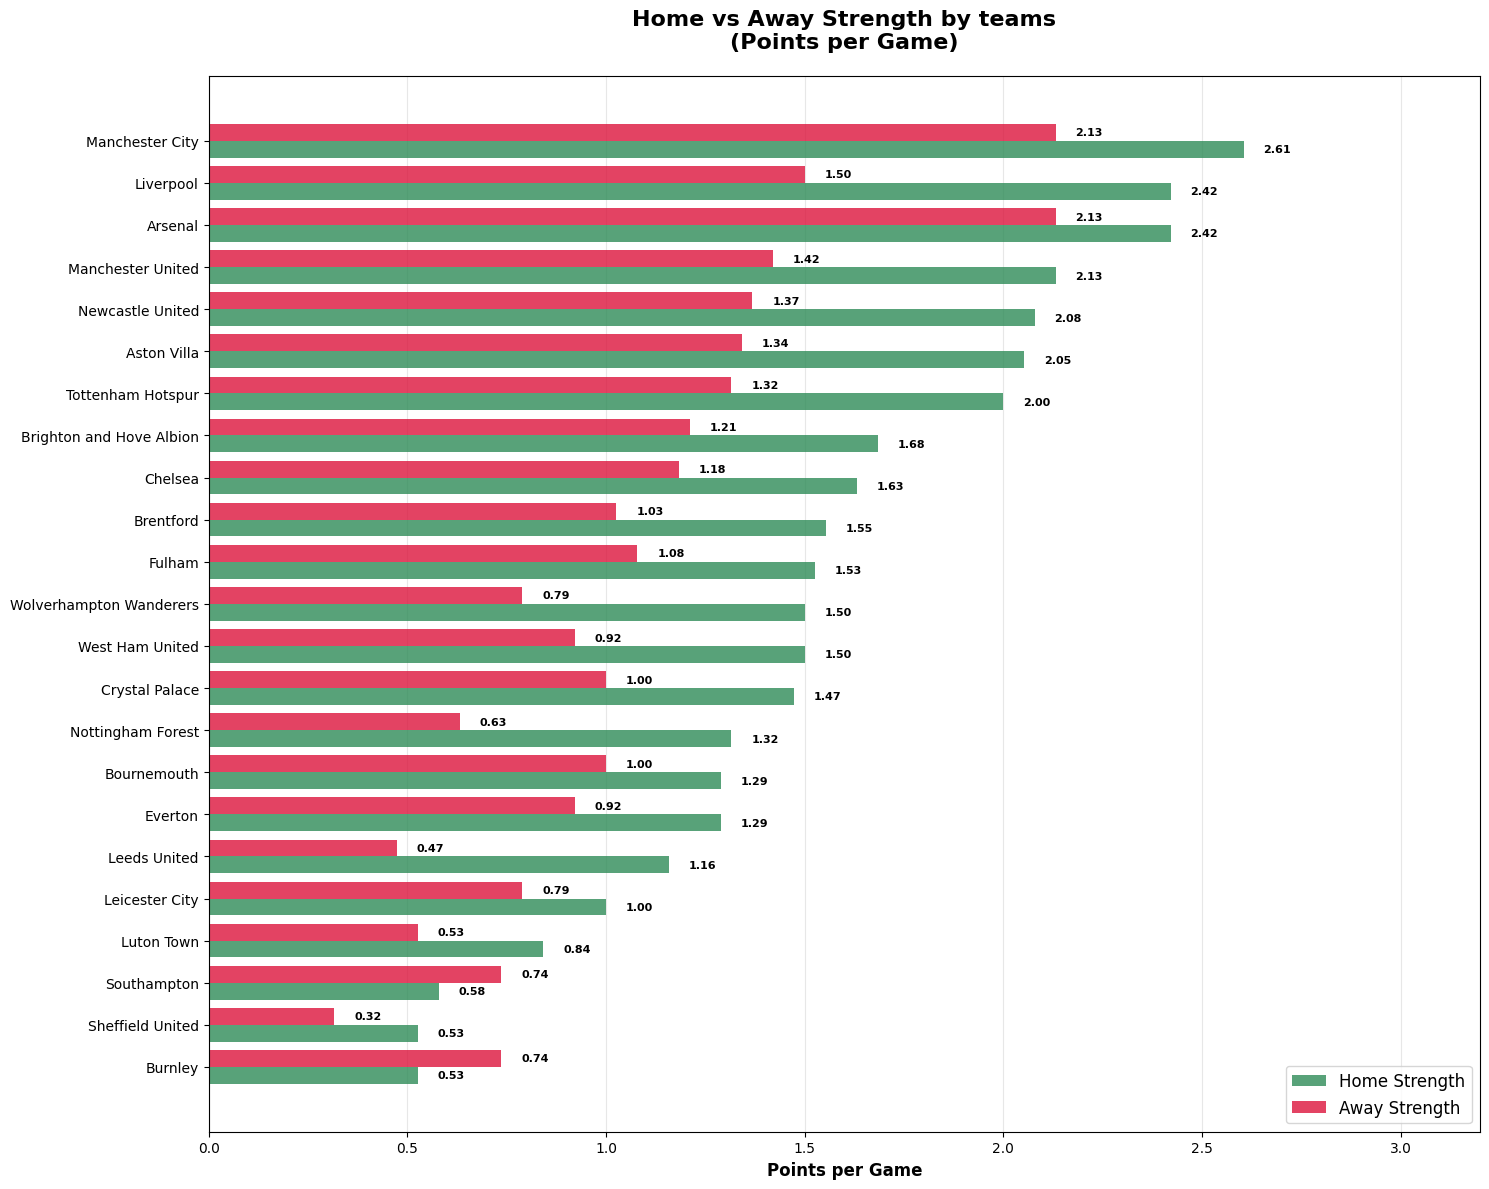

Home vs Away Strength statistics
Mean Strength at Home: 1.53
Mean Strength away from Home: 1.07
Home Advantage (Mean): 0.46

Best Teams at Home:
Liverpool: +0.92 Points
Aston Villa: +0.71 Points
Manchester United: +0.71 Points
Wolverhampton Wanderers: +0.71 Points
Newcastle United: +0.71 Points

Best Teams Away from Home:
Arsenal: 2.13 Points per Game
Manchester City: 2.13 Points per Game
Liverpool: 1.50 Points per Game
Manchester United: 1.42 Points per Game
Newcastle United: 1.37 Points per Game


In [44]:
import matplotlib.pyplot as plt
import numpy as np


def calculate_home_away_strength(df):
    home_stats = df[df['venue'] == 1].groupby('team')['points'].agg(['mean', 'count']).reset_index()
    home_stats.columns = ['team', 'home_strength', 'home_games']


    away_stats = df[df['venue'] == 0].groupby('team')['points'].agg(['mean', 'count']).reset_index()
    away_stats.columns = ['team', 'away_strength', 'away_games']


    strength_df = pd.merge(home_stats, away_stats, on='team', how='outer')
    strength_df = strength_df.fillna(0)

    return strength_df

strength_data = calculate_home_away_strength(df_with_form)


strength_data = strength_data.sort_values('home_strength', ascending=True)


fig, ax = plt.subplots(figsize=(15, 12))


y_pos = np.arange(len(strength_data))


home_bars = ax.barh(y_pos - 0.2, strength_data['home_strength'], 0.4,
                    label='Home Strength', color='#2E8B57', alpha=0.8)
away_bars = ax.barh(y_pos + 0.2, strength_data['away_strength'], 0.4,
                    label='Away Strength', color='#DC143C', alpha=0.8)


ax.set_yticks(y_pos)
ax.set_yticklabels(strength_data['team'], fontsize=10)
ax.set_xlabel('Points per Game', fontsize=12, fontweight='bold')
ax.set_title('Home vs Away Strength by teams\n(Points per Game)',
             fontsize=16, fontweight='bold', pad=20)


ax.legend(loc='lower right', fontsize=12)

ax.grid(axis='x', alpha=0.3)
ax.set_axisbelow(True)

ax.set_xlim(0, 3.2)

for i, (home_val, away_val) in enumerate(zip(strength_data['home_strength'], strength_data['away_strength'])):
    ax.text(home_val + 0.05, i - 0.2, f'{home_val:.2f}',
            va='center', fontsize=8, fontweight='bold')
    ax.text(away_val + 0.05, i + 0.2, f'{away_val:.2f}',
            va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("Home vs Away Strength statistics")
print("="*50)
print(f"Mean Strength at Home: {strength_data['home_strength'].mean():.2f}")
print(f"Mean Strength away from Home: {strength_data['away_strength'].mean():.2f}")
print(f"Home Advantage (Mean): {(strength_data['home_strength'] - strength_data['away_strength']).mean():.2f}")


strength_data['home_advantage'] = strength_data['home_strength'] - strength_data['away_strength']
print(f"\nBest Teams at Home:")
top_home_advantage = strength_data.nlargest(5, 'home_advantage')[['team', 'home_advantage']]
for idx, row in top_home_advantage.iterrows():
    print(f"{row['team']}: +{row['home_advantage']:.2f} Points")

print(f"\nBest Teams Away from Home:")
best_away = strength_data.nlargest(5, 'away_strength')[['team', 'away_strength']]
for idx, row in best_away.iterrows():
    print(f"{row['team']}: {row['away_strength']:.2f} Points per Game")

* xG and Goals Last 10 Matches

  * avg_goals_last_10 and avg_xg_last_10

  * Reflect recent attacking strength and team efficiency (goals vs. expected goals).

* Handling Missing Values: Some teams lacked recent average stats (e.g., beginning of season).

  * Missing values were filled with league-wide averages:

  * Avg. goals: ~1.55

  * Avg. xG: ~1.50

  * Ensures all rows are usable for training without dropping data.

In [45]:
def calculate_goals_xg_avg(df):

    df_sorted = df.sort_values(['team', 'date']).reset_index(drop=True)


    df_sorted['avg_goals_last_10'] = df_sorted.groupby('team')['gf'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )

    df_sorted['avg_xg_last_10'] = df_sorted.groupby('team')['xg'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )

    return df_sorted


df_with_goals_xg = calculate_goals_xg_avg(df_with_form)


print("Example of xG per Game:")
sample_team = df_with_goals_xg[df_with_goals_xg['team'] == 'Manchester City'].tail(10)
print(sample_team[['date', 'team', 'opponent', 'gf', 'xg', 'avg_goals_last_10', 'avg_xg_last_10']].round(2))


print(f"\nStatistics all Teams:")
latest_stats = df_with_goals_xg.groupby('team').tail(1)
print(f"Average Goal/Game (Last 10): {latest_stats['avg_goals_last_10'].mean():.2f}")
print(f"Average xG/Game (Last 10): {latest_stats['avg_xg_last_10'].mean():.2f}")


print(f"\nBest Attack (Most Goals Last 10):")
top_scorers = latest_stats.nlargest(10, 'avg_goals_last_10')[['team', 'avg_goals_last_10']]
for idx, row in top_scorers.iterrows():
    print(f"{row['team']:<20}: {row['avg_goals_last_10']:.2f} Tore/Spiel")


print(f"\nBest Attack (Highest xG last 10):")
top_xg = latest_stats.nlargest(10, 'avg_xg_last_10')[['team', 'avg_xg_last_10']]
for idx, row in top_xg.iterrows():
    print(f"{row['team']:<20}: {row['avg_xg_last_10']:.2f} xG/Spiel")


print(f"\nEfficiency (xG vs. Goals last 10):")
latest_stats['efficiency'] = latest_stats['avg_goals_last_10'] / latest_stats['avg_xg_last_10']
top_efficient = latest_stats.nlargest(10, 'efficiency')[['team', 'efficiency', 'avg_goals_last_10', 'avg_xg_last_10']]
for idx, row in top_efficient.iterrows():
    print(f"{row['team']:<20}: {row['efficiency']:.2f} ({row['avg_goals_last_10']:.2f} Tore / {row['avg_xg_last_10']:.2f} xG)")

Example of xG per Game:
          date             team         opponent  gf   xg  avg_goals_last_10  \
978 2024-03-31  Manchester City          Arsenal   0  1.0                1.8   
979 2024-04-03  Manchester City      Aston Villa   4  3.4                1.9   
980 2024-04-06  Manchester City   Crystal Palace   4  1.9                2.0   
981 2024-04-13  Manchester City       Luton Town   5  4.2                2.2   
982 2024-04-25  Manchester City         Brighton   4  1.4                2.4   
983 2024-04-28  Manchester City  Nott'ham Forest   2  0.9                2.5   
984 2024-05-04  Manchester City           Wolves   5  3.7                2.9   
985 2024-05-11  Manchester City           Fulham   4  3.2                3.2   
986 2024-05-14  Manchester City        Tottenham   2  2.4                3.1   
987 2024-05-19  Manchester City         West Ham   3  1.9                3.3   

     avg_xg_last_10  
978            2.08  
979            2.12  
980            2.14  
981    

In [46]:
def add_goals_xg_to_matches_better(matches_df, goals_xg_df):
    matches_enhanced = matches_df.copy()

    home_avg_goals = []
    home_avg_xg = []
    away_avg_goals = []
    away_avg_xg = []

    for idx, match in matches_df.iterrows():
        date = match['date']
        home_team = match['home_team']
        away_team = match['away_team']


        home_stats = goals_xg_df[
            (goals_xg_df['team'] == home_team) &
            (goals_xg_df['date'] <= date)
        ].sort_values('date').tail(1)


        away_stats = goals_xg_df[
            (goals_xg_df['team'] == away_team) &
            (goals_xg_df['date'] <= date)
        ].sort_values('date').tail(1)


        if idx < 3:
            print(f"Match {idx}: {home_team} vs {away_team} am {date}")
            print(f"  Home stats found: {len(home_stats)} (last game: {home_stats['date'].iloc[0] if len(home_stats) > 0 else 'None'})")
            print(f"  Away stats found: {len(away_stats)} (last game: {away_stats['date'].iloc[0] if len(away_stats) > 0 else 'None'})")


        home_avg_goals.append(home_stats['avg_goals_last_10'].iloc[0] if len(home_stats) > 0 else None)
        home_avg_xg.append(home_stats['avg_xg_last_10'].iloc[0] if len(home_stats) > 0 else None)
        away_avg_goals.append(away_stats['avg_goals_last_10'].iloc[0] if len(away_stats) > 0 else None)
        away_avg_xg.append(away_stats['avg_xg_last_10'].iloc[0] if len(away_stats) > 0 else None)

    matches_enhanced['home_avg_goals_10'] = home_avg_goals
    matches_enhanced['home_avg_xg_10'] = home_avg_xg
    matches_enhanced['away_avg_goals_10'] = away_avg_goals
    matches_enhanced['away_avg_xg_10'] = away_avg_xg

    return matches_enhanced


matches_enhanced_v2 = add_goals_xg_to_matches_better(matches_with_form, df_with_goals_xg)


print(f"\nNaN-Values with new method:")
print(f"Home avg goals: {matches_enhanced_v2['home_avg_goals_10'].isna().sum()}")
print(f"Away avg goals: {matches_enhanced_v2['away_avg_goals_10'].isna().sum()}")


print(f"\nFirst 5 Matches:")
print(matches_enhanced_v2[['date', 'home_team', 'away_team', 'home_avg_goals_10', 'away_avg_goals_10']].head().round(2))

Match 0: Crystal Palace vs Arsenal am 2022-08-05 00:00:00
  Home stats found: 1 (last game: 2022-08-05 00:00:00)
  Away stats found: 1 (last game: 2022-08-05 00:00:00)
Match 1: Fulham vs Liverpool am 2022-08-06 00:00:00
  Home stats found: 1 (last game: 2022-08-06 00:00:00)
  Away stats found: 1 (last game: 2022-08-06 00:00:00)
Match 2: Newcastle United vs Nott'ham Forest am 2022-08-06 00:00:00
  Home stats found: 1 (last game: 2022-08-06 00:00:00)
  Away stats found: 0 (last game: None)

NaN-Values with new method:
Home avg goals: 0
Away avg goals: 285

First 5 Matches:
        date          home_team        away_team  home_avg_goals_10  \
0 2022-08-05     Crystal Palace          Arsenal                0.0   
1 2022-08-06             Fulham        Liverpool                2.0   
2 2022-08-06   Newcastle United  Nott'ham Forest                2.0   
3 2022-08-06  Tottenham Hotspur      Southampton                4.0   
4 2022-08-06        Bournemouth      Aston Villa                2.0

In [47]:
matches_enhanced_v2.head()

,date,time,home_team,away_team,home_goals,away_goals,home_xg,away_xg,home_poss,comp,...,day,referee,season,result,home_team_form,away_team_form,home_avg_goals_10,home_avg_xg_10,away_avg_goals_10,away_avg_xg_10
0,2022-08-05,20:00 (21:00),Crystal Palace,Arsenal,0,2,1.2,1.0,56,Premier League,...,Fri,Anthony Taylor,2023,-1,0.0,3.0,0.0,1.2,2.0,1.0
1,2022-08-06,12:30 (13:30),Fulham,Liverpool,2,2,1.2,1.2,33,Premier League,...,Sat,Andy Madley,2023,0,1.0,1.0,2.0,1.2,2.0,1.2
2,2022-08-06,15:00 (16:00),Newcastle United,Nott'ham Forest,2,0,1.7,0.3,61,Premier League,...,Sat,Simon Hooper,2023,1,3.0,1.5,2.0,1.7,NaN,NaN
3,2022-08-06,15:00 (16:00),Tottenham Hotspur,Southampton,4,1,1.5,0.5,58,Premier League,...,Sat,Andre Marriner,2023,1,3.0,0.0,4.0,1.5,1.0,0.5
4,2022-08-06,15:00 (16:00),Bournemouth,Aston Villa,2,0,0.6,0.7,35,Premier League,...,Sat,Peter Bankes,2023,1,3.0,0.0,2.0,0.6,0.0,0.7


In [48]:
avg_goals_league = df_with_goals_xg['gf'].mean()
avg_xg_league = df_with_goals_xg['xg'].mean()

print(f"Average Goal/Game: {avg_goals_league:.2f}")
print(f"Average xG/Game: {avg_xg_league:.2f}")


matches_enhanced_v2['home_avg_goals_10'] = matches_enhanced_v2['home_avg_goals_10'].fillna(avg_goals_league)
matches_enhanced_v2['home_avg_xg_10'] = matches_enhanced_v2['home_avg_xg_10'].fillna(avg_xg_league)
matches_enhanced_v2['away_avg_goals_10'] = matches_enhanced_v2['away_avg_goals_10'].fillna(avg_goals_league)
matches_enhanced_v2['away_avg_xg_10'] = matches_enhanced_v2['away_avg_xg_10'].fillna(avg_xg_league)


print(f"\nAfter Filling:")
print(f"Home avg goals NaN: {matches_enhanced_v2['home_avg_goals_10'].isna().sum()}")
print(f"Away avg goals NaN: {matches_enhanced_v2['away_avg_goals_10'].isna().sum()}")

print(f"\nFirst 5 Matches after Filling the nan:")
print(matches_enhanced_v2[['date', 'home_team', 'away_team', 'home_avg_goals_10', 'away_avg_goals_10', 'result']].head().round(2))


final_matches = matches_enhanced_v2.copy()
print(f"\nFinal Dataset {len(final_matches)}")

Average Goal/Game: 1.53
Average xG/Game: 1.48

After Filling:
Home avg goals NaN: 0
Away avg goals NaN: 0

First 5 Matches after Filling the nan:
        date          home_team        away_team  home_avg_goals_10  \
0 2022-08-05     Crystal Palace          Arsenal                0.0   
1 2022-08-06             Fulham        Liverpool                2.0   
2 2022-08-06   Newcastle United  Nott'ham Forest                2.0   
3 2022-08-06  Tottenham Hotspur      Southampton                4.0   
4 2022-08-06        Bournemouth      Aston Villa                2.0   

   away_avg_goals_10  result  
0               2.00      -1  
1               2.00       0  
2               1.53       1  
3               1.00       1  
4               0.00       1  

Final Dataset 760


* Goals Conceded Last 10 Matches

  * avg_goals_conceded_last_10

  * Quantifies recent defensive strength.

In [49]:
def add_goals_conceded_avg(df):
    df_sorted = df.sort_values(['team', 'date']).reset_index(drop=True)

    df_sorted['avg_goals_conceded_last_10'] = df_sorted.groupby('team')['ga'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )

    return df_sorted


df_with_defense = add_goals_conceded_avg(df_with_goals_xg)


print("Example of Goals against (last 10):")
sample_team = df_with_defense[df_with_defense['team'] == 'Manchester City'].tail(10)
print(sample_team[['date', 'team', 'opponent', 'ga', 'avg_goals_conceded_last_10']].round(2))


latest_defense = df_with_defense.groupby('team').tail(1)
print(f"\nLeast Goals Conceded (last 10):")
best_defense = latest_defense.nsmallest(10, 'avg_goals_conceded_last_10')[['team', 'avg_goals_conceded_last_10']]
for idx, row in best_defense.iterrows():
    print(f"{row['team']:<20}: {row['avg_goals_conceded_last_10']:.2f} Gegentore/Spiel")

print(f"\nMost Goals Conceded (last 10):")
worst_defense = latest_defense.nlargest(10, 'avg_goals_conceded_last_10')[['team', 'avg_goals_conceded_last_10']]
for idx, row in worst_defense.iterrows():
    print(f"{row['team']:<20}: {row['avg_goals_conceded_last_10']:.2f} Gegentore/Spiel")

Example of Goals against (last 10):
          date             team         opponent  ga  \
978 2024-03-31  Manchester City          Arsenal   0   
979 2024-04-03  Manchester City      Aston Villa   1   
980 2024-04-06  Manchester City   Crystal Palace   2   
981 2024-04-13  Manchester City       Luton Town   1   
982 2024-04-25  Manchester City         Brighton   0   
983 2024-04-28  Manchester City  Nott'ham Forest   0   
984 2024-05-04  Manchester City           Wolves   1   
985 2024-05-11  Manchester City           Fulham   0   
986 2024-05-14  Manchester City        Tottenham   0   
987 2024-05-19  Manchester City         West Ham   1   

     avg_goals_conceded_last_10  
978                         0.7  
979                         0.6  
980                         0.7  
981                         0.7  
982                         0.7  
983                         0.6  
984                         0.7  
985                         0.7  
986                         0.6  
987    

In [50]:
def add_defense_to_matches(matches_df, defense_df):
    matches_def = matches_df.copy()

    home_avg_conceded = []
    away_avg_conceded = []

    for idx, match in matches_df.iterrows():
        date = match['date']
        home_team = match['home_team']
        away_team = match['away_team']


        home_def = defense_df[
            (defense_df['team'] == home_team) &
            (defense_df['date'] <= date)
        ].sort_values('date').tail(1)


        away_def = defense_df[
            (defense_df['team'] == away_team) &
            (defense_df['date'] <= date)
        ].sort_values('date').tail(1)

        home_avg_conceded.append(home_def['avg_goals_conceded_last_10'].iloc[0] if len(home_def) > 0 else None)
        away_avg_conceded.append(away_def['avg_goals_conceded_last_10'].iloc[0] if len(away_def) > 0 else None)

    matches_def['home_avg_conceded_10'] = home_avg_conceded
    matches_def['away_avg_conceded_10'] = away_avg_conceded

    return matches_def


final_matches_with_defense = add_defense_to_matches(final_matches, df_with_defense)


avg_conceded_league = df_with_defense['ga'].mean()
print(f"League Average Goals Conceded: {avg_conceded_league:.2f}")

final_matches_with_defense['home_avg_conceded_10'] = final_matches_with_defense['home_avg_conceded_10'].fillna(avg_conceded_league)
final_matches_with_defense['away_avg_conceded_10'] = final_matches_with_defense['away_avg_conceded_10'].fillna(avg_conceded_league)

print(final_matches_with_defense[['date', 'home_team', 'away_team',
                                  'home_avg_goals_10', 'home_avg_conceded_10',
                                  'away_avg_goals_10', 'away_avg_conceded_10', 'result']].head().round(2))

print(f"\nDataset Shape: {final_matches_with_defense.shape}")
print(f"Features: {final_matches_with_defense.columns.tolist()}")

League Average Goals Conceded: 1.53
        date          home_team        away_team  home_avg_goals_10  \
0 2022-08-05     Crystal Palace          Arsenal                0.0   
1 2022-08-06             Fulham        Liverpool                2.0   
2 2022-08-06   Newcastle United  Nott'ham Forest                2.0   
3 2022-08-06  Tottenham Hotspur      Southampton                4.0   
4 2022-08-06        Bournemouth      Aston Villa                2.0   

   home_avg_conceded_10  away_avg_goals_10  away_avg_conceded_10  result  
0                   2.0               2.00                  0.00      -1  
1                   2.0               2.00                  2.00       0  
2                   0.0               1.53                  1.53       1  
3                   1.0               1.00                  4.00       1  
4                   0.0               0.00                  2.00       1  

Dataset Shape: (760, 23)
Features: ['date', 'time', 'home_team', 'away_team', 'home_go

* Head-to-Head (H2H) Score
  * Normalized historical score between matchups:
  * Adds psychological or stylistic dominance context.
  * Captures rivalry dynamics not visible in recent form alone.

In [51]:
def calculate_h2h_stats(matches_df):
    matches_h2h = matches_df.copy()
    h2h_stats = []

    for idx, match in matches_df.iterrows():
        current_date = match['date']
        home_team = match['home_team']
        away_team = match['away_team']


        previous_h2h = matches_df[
            (matches_df['date'] < current_date) &
            (
                ((matches_df['home_team'] == home_team) & (matches_df['away_team'] == away_team)) |
                ((matches_df['home_team'] == away_team) & (matches_df['away_team'] == home_team))
            )
        ].sort_values('date')

        if len(previous_h2h) == 0:

            h2h_stat = 0
        else:

            home_team_points = 0

            for _, prev_match in previous_h2h.iterrows():
                if prev_match['home_team'] == home_team:
                    if prev_match['result'] == 1:
                        home_team_points += 1
                    elif prev_match['result'] == 0:
                        home_team_points += 0.5
                else:
                    if prev_match['result'] == -1:
                        home_team_points += 1
                    elif prev_match['result'] == 0:
                        home_team_points += 0.5


            total_games = len(previous_h2h)
            away_team_points = total_games - home_team_points

            h2h_stat = (home_team_points - away_team_points) / total_games

        h2h_stats.append(h2h_stat)


        if idx < 5:
            print(f"Match {idx}: {home_team} vs {away_team}")
            print(f"  Prior H2H Games: {len(previous_h2h) if 'previous_h2h' in locals() else 0}")
            print(f"  H2H Stat: {h2h_stat:.2f}")

    matches_h2h['h2h_stat'] = h2h_stats
    return matches_h2h


final_matches_h2h = calculate_h2h_stats(final_matches_with_defense)


print(f"\nH2H Statistics Distribution:")
print(f"Average: {final_matches_h2h['h2h_stat'].mean():.3f}")
print(f"Min: {final_matches_h2h['h2h_stat'].min():.3f}")
print(f"Max: {final_matches_h2h['h2h_stat'].max():.3f}")
print(f"Amount Matches without H2H: {(final_matches_h2h['h2h_stat'] == 0).sum()}")

sample_matches = final_matches_h2h[['date', 'home_team', 'away_team', 'h2h_stat', 'result']].head(10)
print(sample_matches.round(3))

print(f"\nBiggest H2H Dominance (H2H > 0.5):")
strong_home_h2h = final_matches_h2h[final_matches_h2h['h2h_stat'] > 0.5][['home_team', 'away_team', 'h2h_stat', 'result']]
print(strong_home_h2h.head().round(3))

Match 0: Crystal Palace vs Arsenal
  Prior H2H Games: 0
  H2H Stat: 0.00
Match 1: Fulham vs Liverpool
  Prior H2H Games: 0
  H2H Stat: 0.00
Match 2: Newcastle United vs Nott'ham Forest
  Prior H2H Games: 0
  H2H Stat: 0.00
Match 3: Tottenham Hotspur vs Southampton
  Prior H2H Games: 0
  H2H Stat: 0.00
Match 4: Bournemouth vs Aston Villa
  Prior H2H Games: 0
  H2H Stat: 0.00

H2H Statistics Distribution:
Average: 0.046
Min: -1.000
Max: 1.000
Amount Matches without H2H: 470
        date          home_team        away_team  h2h_stat  result
0 2022-08-05     Crystal Palace          Arsenal       0.0      -1
1 2022-08-06             Fulham        Liverpool       0.0       0
2 2022-08-06   Newcastle United  Nott'ham Forest       0.0       1
3 2022-08-06  Tottenham Hotspur      Southampton       0.0       1
4 2022-08-06        Bournemouth      Aston Villa       0.0       1
5 2022-08-06       Leeds United           Wolves       0.0       1
6 2022-08-06            Everton          Chelsea      

In [52]:
final_matches_h2h.tail()

,date,time,home_team,away_team,home_goals,away_goals,home_xg,away_xg,home_poss,comp,...,result,home_team_form,away_team_form,home_avg_goals_10,home_avg_xg_10,away_avg_goals_10,away_avg_xg_10,home_avg_conceded_10,away_avg_conceded_10,h2h_stat
755,2024-05-19,16:00 (18:00),Brighton and Hove Albion,Manchester Utd,0,2,1.7,1.3,55,Premier League,...,-1,0.8,1.5,0.5,1.14,1.532895,1.484605,1.8,1.532895,1.0
756,2024-05-19,16:00 (18:00),Brentford,Newcastle Utd,2,4,1.1,3.4,54,Premier League,...,-1,1.4,1.5,1.6,1.42,1.532895,1.484605,1.3,1.532895,-1.0
757,2024-05-19,16:00 (18:00),Luton Town,Fulham,2,4,2.0,1.1,41,Premier League,...,-1,0.2,1.0,1.1,0.77,1.500000,1.420000,2.6,1.700000,-1.0
758,2024-05-19,16:00 (18:00),Burnley,Nott'ham Forest,1,2,1.2,1.7,72,Premier League,...,-1,0.8,1.5,1.4,1.51,1.532895,1.484605,1.6,1.532895,0.0
759,2024-05-19,16:00 (18:00),Sheffield United,Tottenham,0,3,1.0,3.1,25,Premier League,...,-1,0.0,1.5,1.1,1.32,1.532895,1.484605,3.0,1.532895,0.0


In [53]:
final_dataset = final_matches_h2h.copy()

print("Final Dataset with all Features:")
print("="*50)

print(f"Dataset Shape: {final_dataset.shape}")
print(f"\nAvailable Features:")
for i, col in enumerate(final_dataset.columns):
    print(f"{i+1:2d}. {col}")

key_features = [
    'date', 'home_team', 'away_team',
    'home_team_form', 'away_team_form',
    'home_avg_goals_10', 'away_avg_goals_10',
    'home_avg_conceded_10', 'away_avg_conceded_10',
    'h2h_stat', 'result'
]

print(f"\nImportant Features:")
print(final_dataset[key_features].head(10).round(3))


print(f"\nNumerical Features")
numerical_features = [
    'home_team_form', 'away_team_form',
    'home_avg_goals_10', 'away_avg_goals_10',
    'home_avg_conceded_10', 'away_avg_conceded_10',
    'h2h_stat', 'result'
]

print(final_dataset[numerical_features].describe().round(3))

print(f"\nMissing Values")
missing_values = final_dataset.isnull().sum()
if missing_values.sum() == 0:
    print("No missing Values")
else:
    print(missing_values[missing_values > 0])

Final Dataset with all Features:
Dataset Shape: (760, 24)

Available Features:
 1. date
 2. time
 3. home_team
 4. away_team
 5. home_goals
 6. away_goals
 7. home_xg
 8. away_xg
 9. home_poss
10. comp
11. round
12. day
13. referee
14. season
15. result
16. home_team_form
17. away_team_form
18. home_avg_goals_10
19. home_avg_xg_10
20. away_avg_goals_10
21. away_avg_xg_10
22. home_avg_conceded_10
23. away_avg_conceded_10
24. h2h_stat

Important Features:
        date          home_team        away_team  home_team_form  \
0 2022-08-05     Crystal Palace          Arsenal             0.0   
1 2022-08-06             Fulham        Liverpool             1.0   
2 2022-08-06   Newcastle United  Nott'ham Forest             3.0   
3 2022-08-06  Tottenham Hotspur      Southampton             3.0   
4 2022-08-06        Bournemouth      Aston Villa             3.0   
5 2022-08-06       Leeds United           Wolves             3.0   
6 2022-08-06            Everton          Chelsea             0.0  

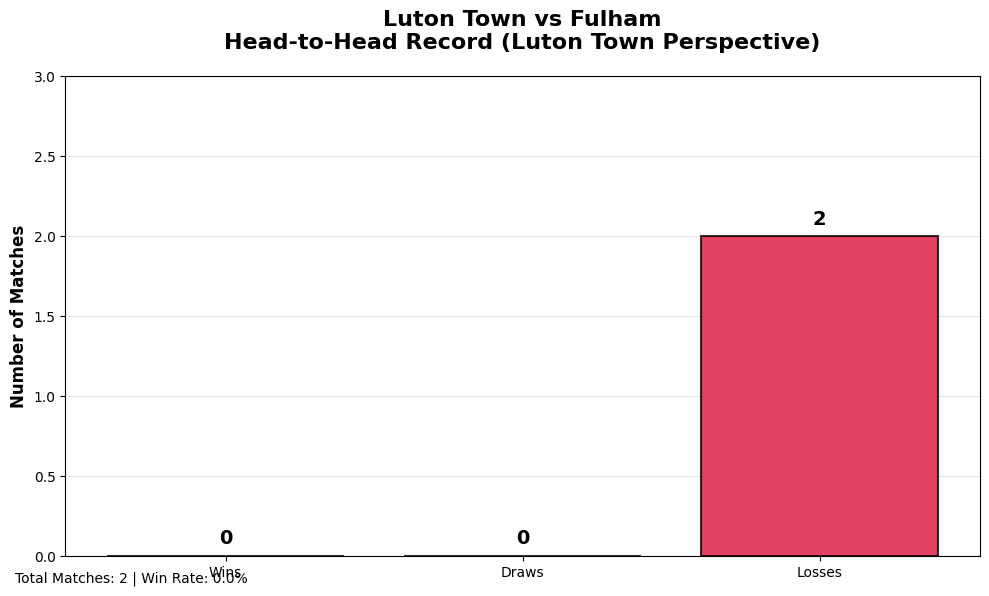


Match History (Luton Town vs Fulham):
2023-09-16: Fulham 1-0 Luton Town
2024-05-19: Luton Town 2-4 Fulham

Summary (From Luton Town Perspective):
Wins: 0, Draws: 0, Losses: 2
Win Rate: 0.0%


In [54]:
import matplotlib.pyplot as plt
import numpy as np


def get_h2h_record(df, team1, team2):
    h2h_matches = df[
        ((df['home_team'] == team1) & (df['away_team'] == team2)) |
        ((df['home_team'] == team2) & (df['away_team'] == team1))
    ].copy()

    if len(h2h_matches) == 0:
        return None, None

    team1_results = []

    for _, match in h2h_matches.iterrows():
        if match['home_team'] == team1:
            if match['result'] == 1:  # Home win
                team1_results.append('Win')
            elif match['result'] == 0:  # Draw
                team1_results.append('Draw')
            else:
                team1_results.append('Loss')
        else:
            if match['result'] == -1:  # Away win (für Team1)
                team1_results.append('Win')
            elif match['result'] == 0:  # Draw
                team1_results.append('Draw')
            else:
                team1_results.append('Loss')

    return team1_results, h2h_matches

team1 = "Luton Town"
team2 = "Fulham"

results, matches = get_h2h_record(final_dataset, team1, team2)

if results is None:
    print(f"No Games found between {team1} and {team2}")


    all_teams = set(final_dataset['home_team'].unique()) | set(final_dataset['away_team'].unique())
    luton_teams = [team for team in all_teams if 'luton' in team.lower()]
    fulham_teams = [team for team in all_teams if 'fulham' in team.lower()]
else:

    from collections import Counter
    result_counts = Counter(results)

    wins = result_counts.get('Win', 0)
    draws = result_counts.get('Draw', 0)
    losses = result_counts.get('Loss', 0)


    categories = ['Wins', 'Draws', 'Losses']
    values = [wins, draws, losses]
    colors = ['#2E8B57', '#FFD700', '#DC143C']

    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)


    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                str(value), ha='center', va='bottom', fontsize=14, fontweight='bold')


    plt.title(f'{team1} vs {team2}\nHead-to-Head Record ({team1} Perspective)',
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Number of Matches', fontsize=12, fontweight='bold')
    plt.ylim(0, max(values) + 1)


    plt.grid(axis='y', alpha=0.3)
    plt.gca().set_axisbelow(True)


    total_matches = len(results)
    win_percentage = (wins / total_matches) * 100 if total_matches > 0 else 0

    plt.figtext(0.02, 0.02, f'\nTotal Matches: {total_matches} | Win Rate: {win_percentage:.1f}%',
                fontsize=10)

    plt.tight_layout()
    plt.show()


    print(f"\nMatch History ({team1} vs {team2}):")
    print("="*60)
    for _, match in matches.iterrows():
        home_team = match['home_team']
        away_team = match['away_team']
        date = match['date'].strftime('%Y-%m-%d')
        home_goals = match['home_goals']
        away_goals = match['away_goals']

        print(f"{date}: {home_team} {home_goals}-{away_goals} {away_team}")

    print(f"\nSummary (From {team1} Perspective):")
    print(f"Wins: {wins}, Draws: {draws}, Losses: {losses}")
    print(f"Win Rate: {win_percentage:.1f}%")

In [55]:
final_dataset.columns

Index(['date', 'time', 'home_team', 'away_team', 'home_goals', 'away_goals',
       'home_xg', 'away_xg', 'home_poss', 'comp', 'round', 'day', 'referee',
       'season', 'result', 'home_team_form', 'away_team_form',
       'home_avg_goals_10', 'home_avg_xg_10', 'away_avg_goals_10',
       'away_avg_xg_10', 'home_avg_conceded_10', 'away_avg_conceded_10',
       'h2h_stat'],
      dtype='object')

In [56]:
final_dataset.to_csv('/content/drive/MyDrive/Premier League Dataset/dataset_after_h2h2.csv', index=False)
# change to final_dataset.to_csv("../data/dataset_after_h2h2.csv") if you run locally

In [57]:
columns_to_drop = ['comp', 'round', 'day', 'season']

existing_columns = [col for col in columns_to_drop if col in final_dataset.columns]
missing_columns = [col for col in columns_to_drop if col not in final_dataset.columns]

print(f"Columns to Drop: {existing_columns}")
if missing_columns:
    print(f"None found: {missing_columns}")


final_dataset_cleaned = final_dataset.drop(columns=existing_columns)

print(f"\nBefore: {final_dataset.shape[1]} Columns")
print(f"After: {final_dataset_cleaned.shape[1]} Columns")

print(f"\nColumns Left:")
for i, col in enumerate(final_dataset_cleaned.columns):
    print(f"{i+1:2d}. {col}")


final_dataset = final_dataset_cleaned.copy()
print(f"Final Dataset: {final_dataset.shape}")

Columns to Drop: ['comp', 'round', 'day', 'season']

Before: 24 Columns
After: 20 Columns

Columns Left:
 1. date
 2. time
 3. home_team
 4. away_team
 5. home_goals
 6. away_goals
 7. home_xg
 8. away_xg
 9. home_poss
10. referee
11. result
12. home_team_form
13. away_team_form
14. home_avg_goals_10
15. home_avg_xg_10
16. away_avg_goals_10
17. away_avg_xg_10
18. home_avg_conceded_10
19. away_avg_conceded_10
20. h2h_stat
Final Dataset: (760, 20)


In [58]:
final_dataset.dtypes

,0
date,datetime64[ns]
time,object
home_team,object
away_team,object
home_goals,int64
away_goals,int64
home_xg,float64
away_xg,float64
home_poss,int64
referee,object


## Referee Bias Indicator

* Identify referees with statistically abnormal win rates favoring specific teams.

* Can be included as a contextual feature or for fairness diagnostics.

* Certain referees appear to consistently favor teams like Manchester City or Liverpool. Might be a misconception though as these are just teams that win a lot regardless who is officiating

Referee Bias Analysis
Referees with more than 3 Games for one team: 239

Referees' Favourite Teams:
Craig Pawson         → Liverpool            (5/5 = 100.0%)
Darren England       → Manchester City      (5/5 = 100.0%)
Stuart Attwell       → Tottenham Hotspur    (4/4 = 100.0%)
Robert Jones         → Manchester City      (6/6 = 100.0%)
Simon Hooper         → Tottenham Hotspur    (5/5 = 100.0%)
Tim Robinson         → Newcastle United     (3/3 = 100.0%)
David Coote          → Manchester City      (3/3 = 100.0%)
Paul Tierney         → Manchester City      (5/6 = 83.3%)
Michael Oliver       → Arsenal              (9/11 = 81.8%)
Jarred Gillett       → Manchester City      (4/5 = 80.0%)
Peter Bankes         → Bournemouth          (3/4 = 75.0%)
John Brooks          → Manchester City      (5/7 = 71.4%)
Andy Madley          → Fulham               (2/3 = 66.7%)
Anthony Taylor       → Aston Villa          (4/6 = 66.7%)
Chris Kavanagh       → Manchester City      (2/3 = 66.7%)

Highest Win Rate by T

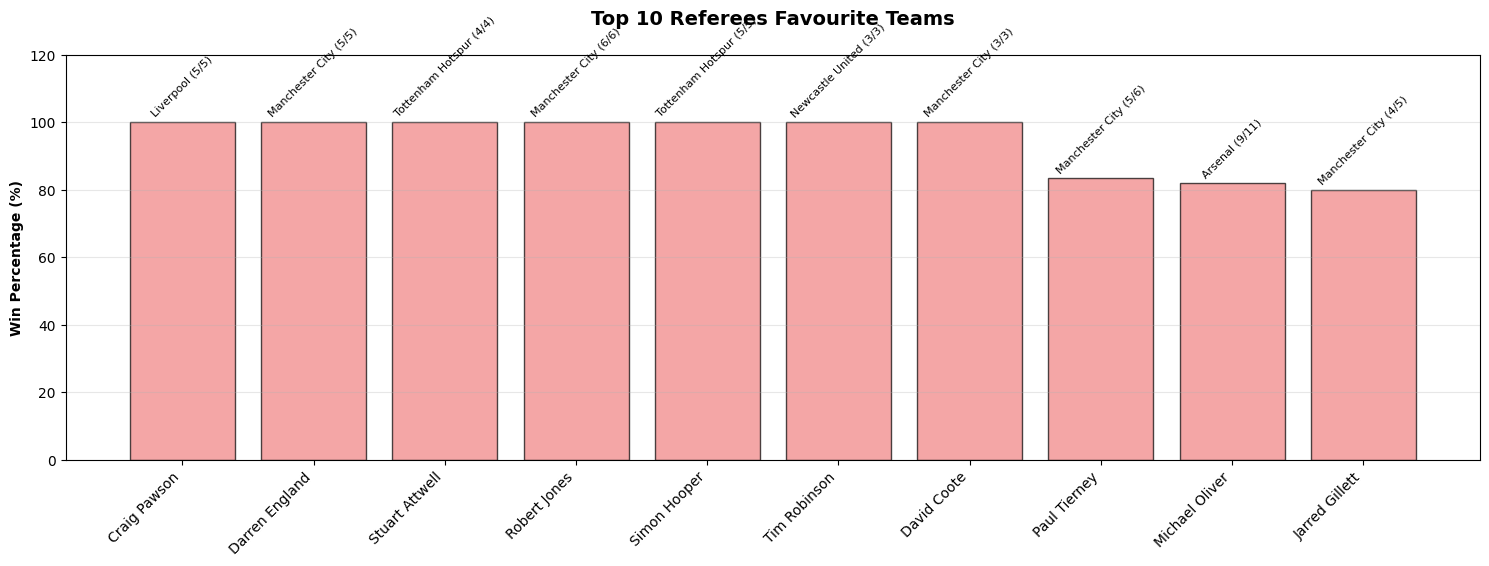

In [59]:
import pandas as pd
import matplotlib.pyplot as plt


def analyze_referee_bias(df):
    referee_stats = []


    for referee in df['referee'].unique():
        if pd.isna(referee):
            continue

        referee_matches = df[df['referee'] == referee]


        all_teams = set(referee_matches['home_team'].unique()) | set(referee_matches['away_team'].unique())

        for team in all_teams:

            team_matches = referee_matches[
                (referee_matches['home_team'] == team) |
                (referee_matches['away_team'] == team)
            ]

            if len(team_matches) >= 3:  # Mindestens 3 Spiele
                wins = 0
                total_games = len(team_matches)

                for _, match in team_matches.iterrows():
                    if match['home_team'] == team:

                        if match['result'] == 1:  # Home win
                            wins += 1
                    else:

                        if match['result'] == -1:
                            wins += 1

                win_percentage = (wins / total_games) * 100

                referee_stats.append({
                    'referee': referee,
                    'team': team,
                    'total_games': total_games,
                    'wins': wins,
                    'win_percentage': win_percentage
                })

    return pd.DataFrame(referee_stats)


referee_bias_df = analyze_referee_bias(final_dataset)

print("Referee Bias Analysis")
print("="*50)
print(f"Referees with more than 3 Games for one team: {len(referee_bias_df)}")


print(f"\nReferees' Favourite Teams:")
print("="*60)

favorite_teams = referee_bias_df.loc[referee_bias_df.groupby('referee')['win_percentage'].idxmax()]
favorite_teams = favorite_teams.sort_values('win_percentage', ascending=False)

for _, row in favorite_teams.head(15).iterrows():
    print(f"{row['referee']:<20} → {row['team']:<20} ({row['wins']}/{row['total_games']} = {row['win_percentage']:.1f}%)")


print(f"\nHighest Win Rate by Teams with Referees with 5 Matches or more:")
print("="*60)

high_games = referee_bias_df[referee_bias_df['total_games'] >= 5]
top_win_rates = high_games.nlargest(15, 'win_percentage')

for _, row in top_win_rates.iterrows():
    print(f"{row['team']:<20} bei {row['referee']:<20}: {row['wins']}/{row['total_games']} = {row['win_percentage']:.1f}%")


plt.figure(figsize=(15, 10))


top_refs = favorite_teams.head(10)

plt.subplot(2, 1, 1)
bars = plt.bar(range(len(top_refs)), top_refs['win_percentage'],
               color='lightcoral', alpha=0.7, edgecolor='black')

for i, (_, row) in enumerate(top_refs.iterrows()):
    plt.text(i, row['win_percentage'] + 1,
             f"{row['team']} ({row['wins']}/{row['total_games']})",
             ha='center', va='bottom', fontsize=8, rotation=45)

plt.title('Top 10 Referees Favourite Teams\n', fontsize=14, fontweight='bold')
plt.ylabel('Win Percentage (%)', fontweight='bold')
plt.xticks(range(len(top_refs)), top_refs['referee'], rotation=45, ha='right')
plt.ylim(0, 120)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()



print(f"\nStatistics:")
print(f"Average Win Rate: {referee_bias_df['win_percentage'].mean():.1f}%")
print(f"Highest Win Rate: {referee_bias_df['win_percentage'].max():.1f}%")
print(f"Lowest Win Rate: {referee_bias_df['win_percentage'].min():.1f}%")
print(f"Amount of Teams with 100% Win Rate: {(referee_bias_df['win_percentage'] == 100).sum()}")
print(f"Amount of Teams with 0% Win Rate: {(referee_bias_df['win_percentage'] == 0).sum()}")

In [60]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

print(final_dataset.dtypes)


label_encoders = {}

categorical_columns = ['home_team', 'away_team', 'referee']


for col in categorical_columns:
    if col in final_dataset.columns:

        unique_count = final_dataset[col].nunique()
        print(f"\n{col}: {unique_count} unique values")


        le = LabelEncoder()
        final_dataset[f'{col}_encoded'] = le.fit_transform(final_dataset[col])


        label_encoders[col] = le


        example_mapping = dict(zip(le.classes_[:5], le.transform(le.classes_[:5])))
        print(f"example Mapping: {example_mapping}")


final_dataset_encoded = final_dataset.copy()

encoded_cols = [col for col in final_dataset_encoded.columns if '_encoded' in col]
print(encoded_cols)

ml_columns = [
    'home_team_encoded', 'away_team_encoded', 'referee_encoded',
    'home_goals', 'away_goals', 'home_xg', 'away_xg', 'home_poss',
    'home_team_form', 'away_team_form',
    'home_avg_goals_10', 'home_avg_xg_10', 'away_avg_goals_10', 'away_avg_xg_10',
    'home_avg_conceded_10', 'away_avg_conceded_10', 'h2h_stat',
    'result'  # Target variable
]


ml_dataset = final_dataset_encoded[ml_columns].copy()

print(f"\nML Dataset Shape: {ml_dataset.shape}")
print(ml_dataset.dtypes)


missing = ml_dataset.isnull().sum()
if missing.sum() == 0:
    print("No missing values")
else:
    print(missing[missing > 0])


print(ml_dataset.head())

for key in label_encoders.keys():
    print(f"- {key}: {len(label_encoders[key].classes_)} classes")

date                    datetime64[ns]
time                            object
home_team                       object
away_team                       object
home_goals                       int64
away_goals                       int64
home_xg                        float64
away_xg                        float64
home_poss                        int64
referee                         object
result                           int64
home_team_form                 float64
away_team_form                 float64
home_avg_goals_10              float64
home_avg_xg_10                 float64
away_avg_goals_10              float64
away_avg_xg_10                 float64
home_avg_conceded_10           float64
away_avg_conceded_10           float64
h2h_stat                       float64
dtype: object

home_team: 23 unique values
example Mapping: {'Arsenal': np.int64(0), 'Aston Villa': np.int64(1), 'Bournemouth': np.int64(2), 'Brentford': np.int64(3), 'Brighton and Hove Albion': np.int64(4)}

away_team: 

In [61]:
ml_dataset.to_csv('/content/drive/MyDrive/Premier League Dataset/dataset_after_encoding.csv', index=False)
# change to ml_dataset.to_csv("../data/dataset_after_encoding.csv") if you run locally

* Average Possession Last 10 Matches

  * avg_possession_last_10 = Average possession percentage over the last 10 games per team.

  * Reflects a team's tactical style and control of the game.

  * Filled with a neutral 50% when 10 prior matches were unavailable.

In [62]:
def add_avg_possession(df):
    df_sorted = df.sort_values(['team', 'date']).reset_index(drop=True)
    df_sorted['avg_possession_last_10'] = df_sorted.groupby('team')['poss'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )

    return df_sorted

df_with_possession = add_avg_possession(df_with_defense)


sample_team = df_with_possession[df_with_possession['team'] == 'Manchester City'].tail(10)
print(sample_team[['date', 'team', 'opponent', 'poss', 'avg_possession_last_10']].round(1))

latest_poss_stats = df_with_possession.groupby('team').tail(1)
print(f"\nPossession Statistics:")
print(f"Average Possession: {latest_poss_stats['avg_possession_last_10'].mean():.1f}%")


print(f"\nAverage Possession (Last 10 Games):")
top_possession = latest_poss_stats.nlargest(10, 'avg_possession_last_10')[['team', 'avg_possession_last_10']]
for idx, row in top_possession.iterrows():
    print(f"{row['team']:<20}: {row['avg_possession_last_10']:.1f}%")

print(f"\nTeams with lowest average Possession last 10:")
low_possession = latest_poss_stats.nsmallest(10, 'avg_possession_last_10')[['team', 'avg_possession_last_10']]
for idx, row in low_possession.iterrows():
    print(f"{row['team']:<20}: {row['avg_possession_last_10']:.1f}%")


def add_possession_to_matches(matches_df, possession_df):
    matches_poss = matches_df.copy()

    home_avg_poss = []
    away_avg_poss = []

    for idx, match in matches_df.iterrows():
        date = match['date']
        home_team = match['home_team']
        away_team = match['away_team']


        home_poss = possession_df[
            (possession_df['team'] == home_team) &
            (possession_df['date'] <= date)
        ].sort_values('date').tail(1)


        away_poss = possession_df[
            (possession_df['team'] == away_team) &
            (possession_df['date'] <= date)
        ].sort_values('date').tail(1)

        home_avg_poss.append(home_poss['avg_possession_last_10'].iloc[0] if len(home_poss) > 0 else None)
        away_avg_poss.append(away_poss['avg_possession_last_10'].iloc[0] if len(away_poss) > 0 else None)

    matches_poss['home_avg_possession_10'] = home_avg_poss
    matches_poss['away_avg_possession_10'] = away_avg_poss

    return matches_poss

final_dataset_with_poss = add_possession_to_matches(final_dataset, df_with_possession)


print(f"Home possession NaN: {final_dataset_with_poss['home_avg_possession_10'].isna().sum()}")
print(f"Away possession NaN: {final_dataset_with_poss['away_avg_possession_10'].isna().sum()}")

final_dataset_with_poss['home_avg_possession_10'] = final_dataset_with_poss['home_avg_possession_10'].fillna(50.0)
final_dataset_with_poss['away_avg_possession_10'] = final_dataset_with_poss['away_avg_possession_10'].fillna(50.0)

print(f"Home possession NaN: {final_dataset_with_poss['home_avg_possession_10'].isna().sum()}")
print(f"Away possession NaN: {final_dataset_with_poss['away_avg_possession_10'].isna().sum()}")

print(final_dataset_with_poss[['date', 'home_team', 'away_team',
                               'home_avg_possession_10', 'away_avg_possession_10', 'result']].head().round(1))


final_dataset = final_dataset_with_poss.copy()

print(f"\nDataset Shape: {final_dataset.shape}")

          date             team         opponent  poss  avg_possession_last_10
978 2024-03-31  Manchester City          Arsenal    72                    68.4
979 2024-04-03  Manchester City      Aston Villa    67                    67.9
980 2024-04-06  Manchester City   Crystal Palace    75                    68.0
981 2024-04-13  Manchester City       Luton Town    73                    68.1
982 2024-04-25  Manchester City         Brighton    64                    67.3
983 2024-04-28  Manchester City  Nott'ham Forest    66                    66.9
984 2024-05-04  Manchester City           Wolves    58                    65.7
985 2024-05-11  Manchester City           Fulham    64                    65.9
986 2024-05-14  Manchester City        Tottenham    47                    63.3
987 2024-05-19  Manchester City         West Ham    71                    65.7

Possession Statistics:
Average Possession: 48.9%

Average Possession (Last 10 Games):
Manchester City     : 65.7%
Liverpool       

* Removing Leakage Features

  * Some features contain future match outcomes and cannot be used at prediction time.

  * Examples of dropped columns:
    * home_goals, away_goals, home_xg, away_xg, home_poss, etc.

  * To prevent data leakage and ensure model generalization.

In [63]:
leakage_features = [
    'home_goals',
    'away_goals',
    'home_xg',
    'away_xg',
    'home_poss',
    'time'
]

for feature in leakage_features:
    if feature in final_dataset.columns:
        print(f"{feature} dropped")
    else:
        print(f"{feature} not found")


clean_features = [col for col in final_dataset.columns if col not in leakage_features]

ml_ready_dataset = final_dataset[clean_features].copy()

print(f"\nBefore: {final_dataset.shape[1]} Features")
print(f"After: {ml_ready_dataset.shape[1]} Features")

for i, col in enumerate(ml_ready_dataset.columns):
    print(f"{i+1:2d}. {col}")


prediction_features = [
    'home_team_encoded', 'away_team_encoded', 'referee_encoded',
    'home_team_form', 'away_team_form',
    'home_avg_goals_10', 'home_avg_xg_10', 'away_avg_goals_10', 'away_avg_xg_10',
    'home_avg_conceded_10', 'away_avg_conceded_10',
    'home_avg_possession_10', 'away_avg_possession_10',
    'h2h_stat'
]

target = 'result'


missing_features = [f for f in prediction_features if f not in ml_ready_dataset.columns]
if missing_features:
    print(f"\nMissing Features: {missing_features}")
    categorical_columns = ['home_team', 'away_team', 'referee']
    for col in categorical_columns:
        if col in ml_ready_dataset.columns and f'{col}_encoded' not in ml_ready_dataset.columns:
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            ml_ready_dataset[f'{col}_encoded'] = le.fit_transform(ml_ready_dataset[col])
            if col not in label_encoders:
                label_encoders[col] = le


available_features = [f for f in prediction_features if f in ml_ready_dataset.columns]
X = ml_ready_dataset[available_features]
y = ml_ready_dataset[target]

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

print(f"\nFeature List For Predictions:")
for i, feature in enumerate(available_features):
    print(f"{i+1:2d}. {feature}")

print(f"\nTarget Distribution:")
print(y.value_counts().sort_index())
target_labels = {-1: 'Away Win', 0: 'Draw', 1: 'Home Win'}
for value, count in y.value_counts().sort_index().items():
    print(f"{target_labels[value]}: {count} ({count/len(y)*100:.1f}%)")

home_goals dropped
away_goals dropped
home_xg dropped
away_xg dropped
home_poss dropped
time dropped

Before: 25 Features
After: 19 Features
 1. date
 2. home_team
 3. away_team
 4. referee
 5. result
 6. home_team_form
 7. away_team_form
 8. home_avg_goals_10
 9. home_avg_xg_10
10. away_avg_goals_10
11. away_avg_xg_10
12. home_avg_conceded_10
13. away_avg_conceded_10
14. h2h_stat
15. home_team_encoded
16. away_team_encoded
17. referee_encoded
18. home_avg_possession_10
19. away_avg_possession_10
Features (X): (760, 14)
Target (y): (760,)

Feature List For Predictions:
 1. home_team_encoded
 2. away_team_encoded
 3. referee_encoded
 4. home_team_form
 5. away_team_form
 6. home_avg_goals_10
 7. home_avg_xg_10
 8. away_avg_goals_10
 9. away_avg_xg_10
10. home_avg_conceded_10
11. away_avg_conceded_10
12. home_avg_possession_10
13. away_avg_possession_10
14. h2h_stat

Target Distribution:
result
-1    232
 0    169
 1    359
Name: count, dtype: int64
Away Win: 232 (30.5%)
Draw: 169 (22.2%

## 5. Probabilistic Modeling Approach


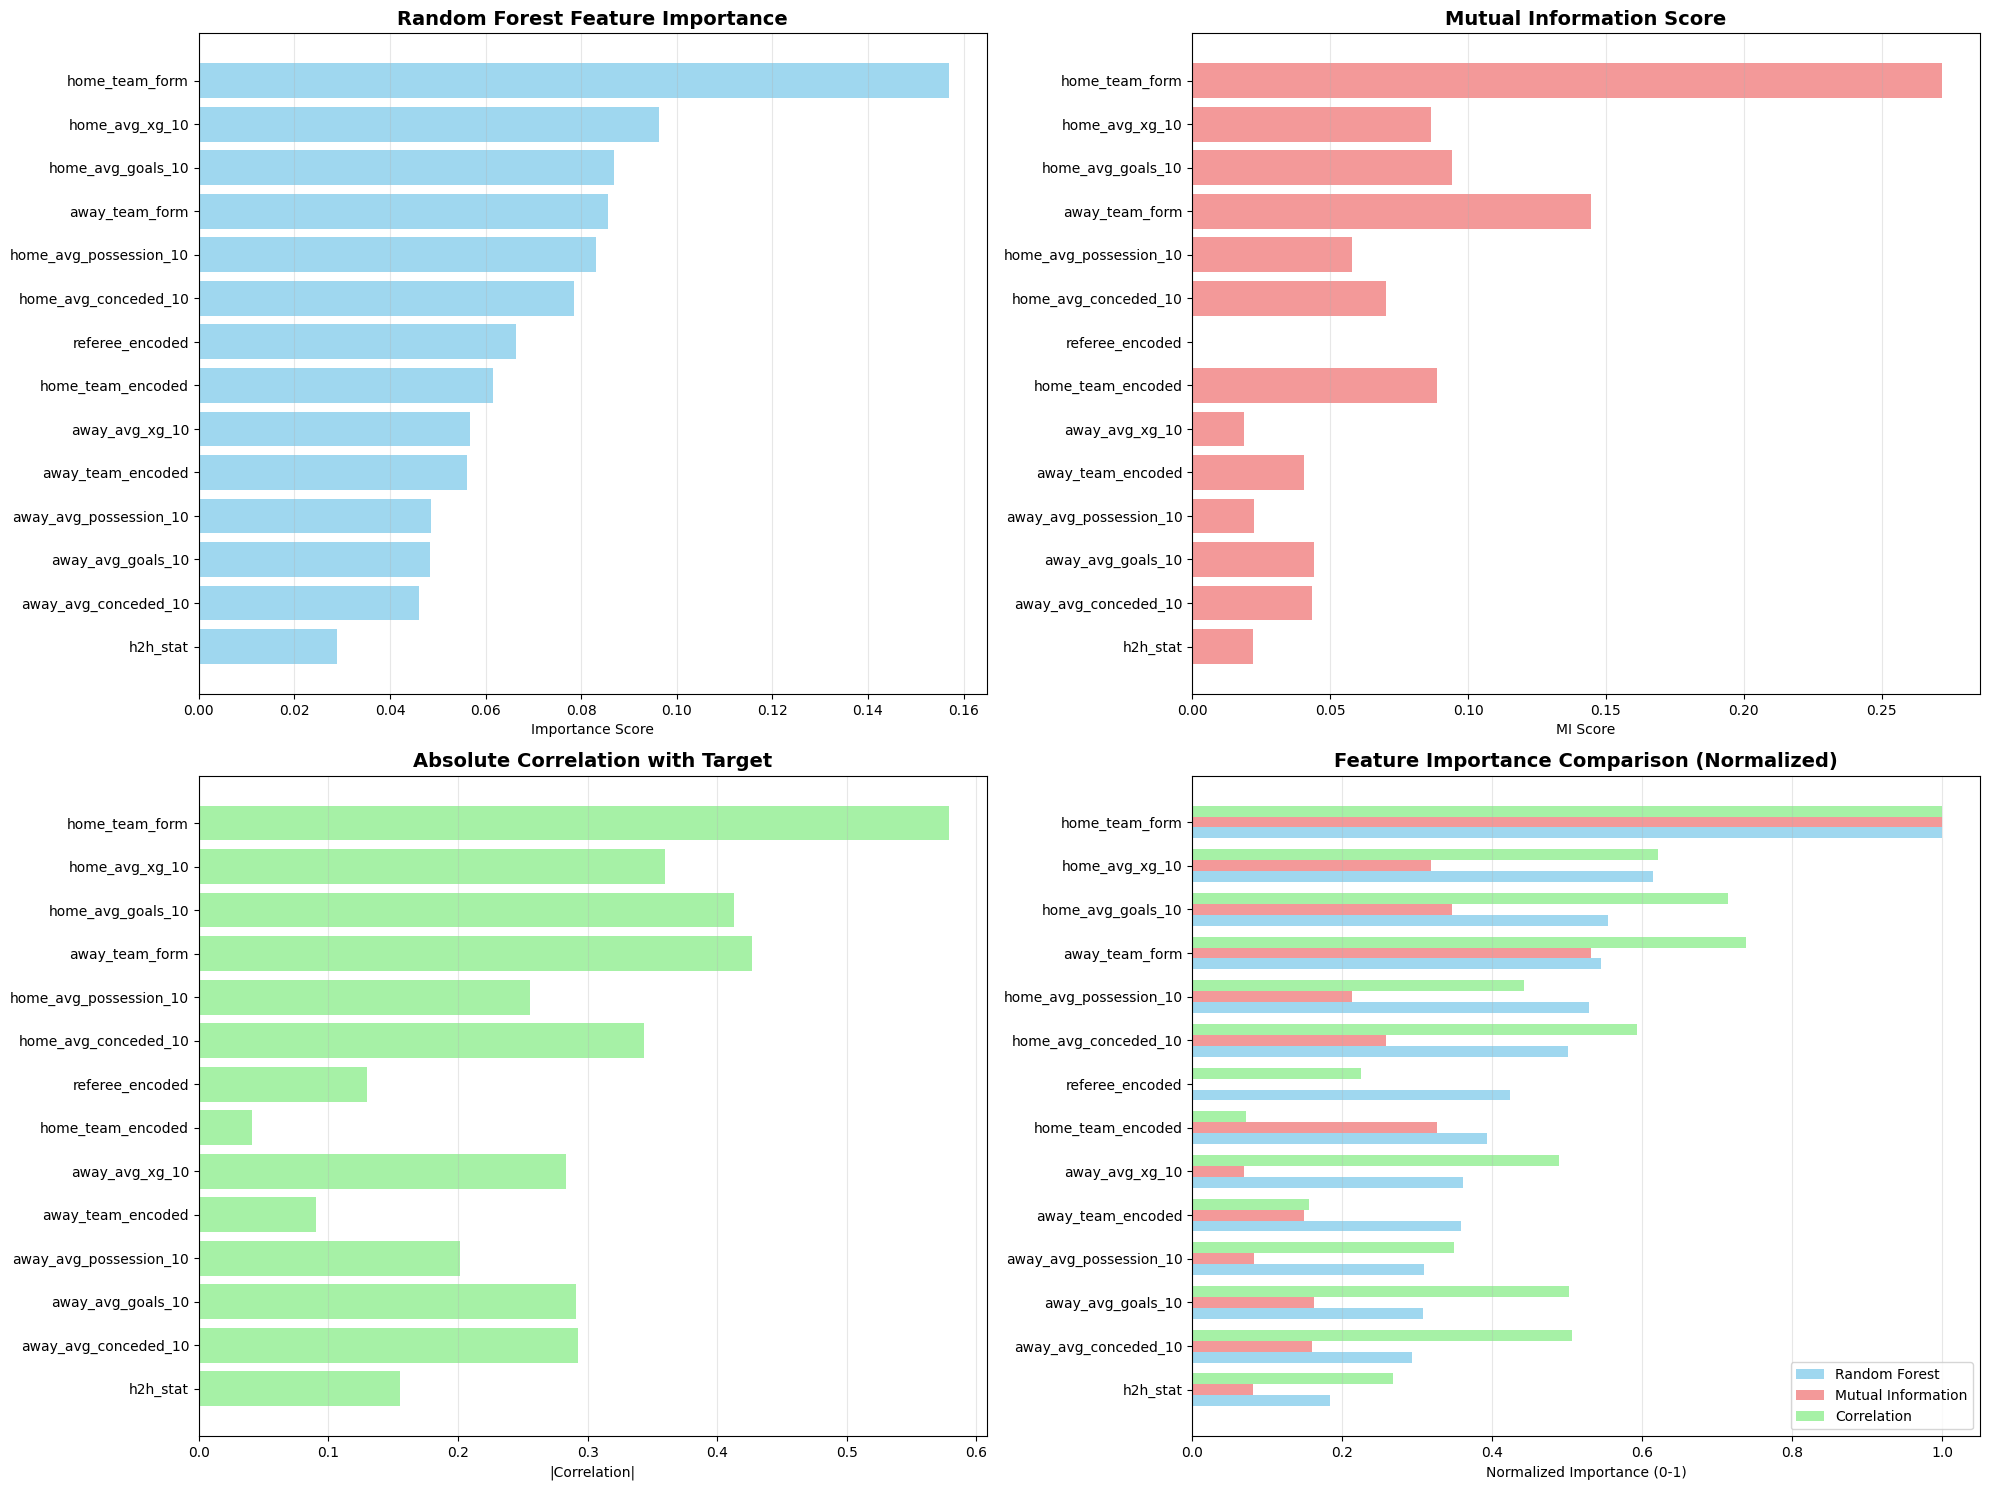

Feature Importance Rankings:

Top 10 Features (Random Forest):
 1. home_team_form           : 0.1570
 2. home_avg_xg_10           : 0.0964
 3. home_avg_goals_10        : 0.0869
 4. away_team_form           : 0.0856
 5. home_avg_possession_10   : 0.0831
 6. home_avg_conceded_10     : 0.0785
 7. referee_encoded          : 0.0664
 8. home_team_encoded        : 0.0616
 9. away_avg_xg_10           : 0.0567
10. away_team_encoded        : 0.0562

Top 10 Features (Mutual Information):
 1. home_team_form           : 0.2720
 2. away_team_form           : 0.1444
 3. home_avg_goals_10        : 0.0941
 4. home_team_encoded        : 0.0889
 5. home_avg_xg_10           : 0.0865
 6. home_avg_conceded_10     : 0.0703
 7. home_avg_possession_10   : 0.0580
 8. away_avg_goals_10        : 0.0443
 9. away_avg_conceded_10     : 0.0433
10. away_team_encoded        : 0.0404

Top 10 Features (Correlation):
 1. home_team_form           : 0.5790
 2. away_team_form           : 0.4271
 3. home_avg_goals_10        :

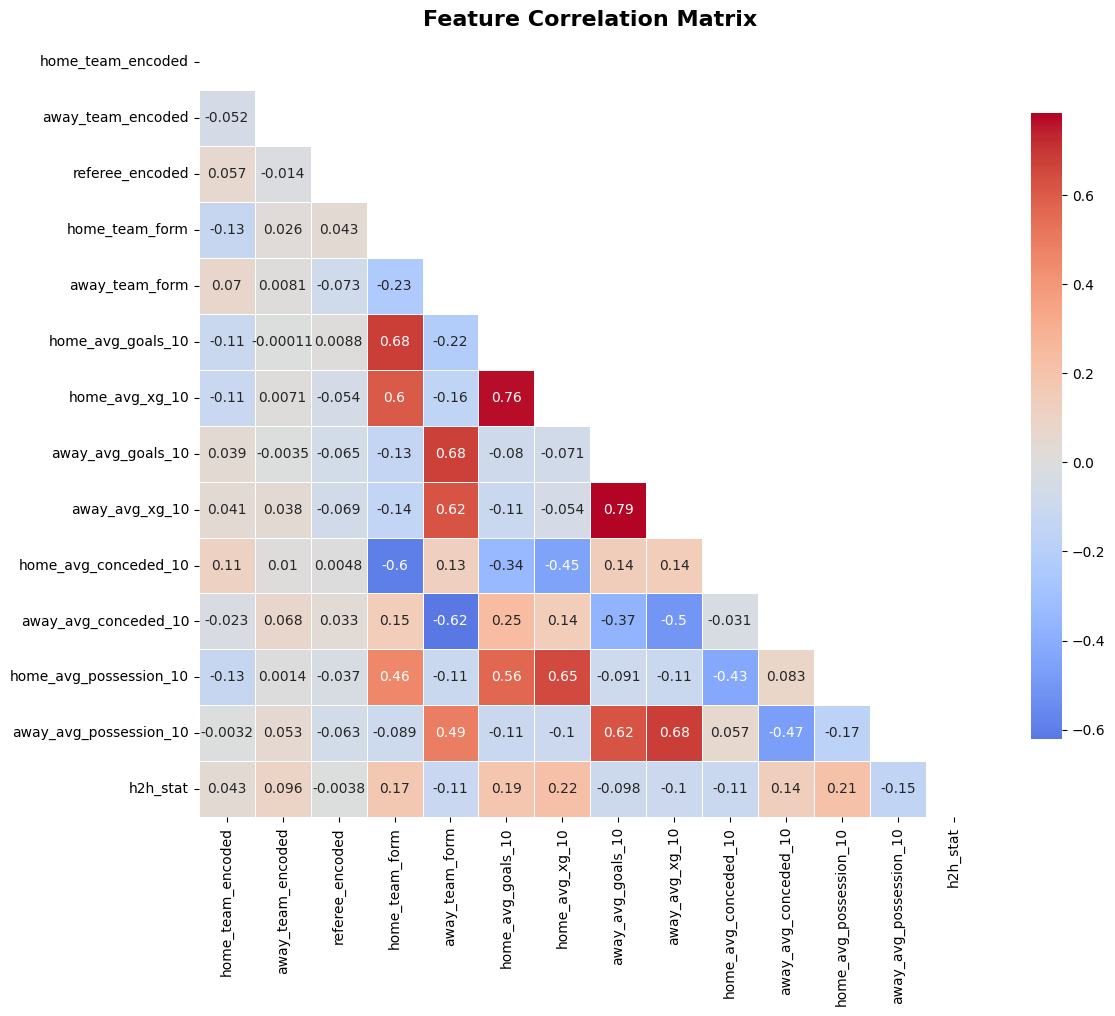

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
import numpy as np


def analyze_feature_importance(X, y):
    feature_names = X.columns


    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    rf_importance = rf.feature_importances_


    mi_scores = mutual_info_classif(X, y, random_state=42)


    correlations = []
    for feature in feature_names:
        corr = abs(np.corrcoef(X[feature], y)[0, 1])
        correlations.append(corr)


    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Random_Forest': rf_importance,
        'Mutual_Information': mi_scores,
        'Correlation': correlations
    })


    for col in ['Random_Forest', 'Mutual_Information', 'Correlation']:
        importance_df[f'{col}_normalized'] = importance_df[col] / importance_df[col].max()

    return importance_df


importance_results = analyze_feature_importance(X, y)


importance_results = importance_results.sort_values('Random_Forest', ascending=True)


fig, axes = plt.subplots(2, 2, figsize=(20, 15))


axes[0, 0].barh(importance_results['Feature'], importance_results['Random_Forest'],
                color='skyblue', alpha=0.8)
axes[0, 0].set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Importance Score')
axes[0, 0].grid(axis='x', alpha=0.3)


axes[0, 1].barh(importance_results['Feature'], importance_results['Mutual_Information'],
                color='lightcoral', alpha=0.8)
axes[0, 1].set_title('Mutual Information Score', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('MI Score')
axes[0, 1].grid(axis='x', alpha=0.3)


axes[1, 0].barh(importance_results['Feature'], importance_results['Correlation'],
                color='lightgreen', alpha=0.8)
axes[1, 0].set_title('Absolute Correlation with Target', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('|Correlation|')
axes[1, 0].grid(axis='x', alpha=0.3)


width = 0.25
x_pos = np.arange(len(importance_results))

axes[1, 1].barh(x_pos - width, importance_results['Random_Forest_normalized'],
                width, label='Random Forest', alpha=0.8, color='skyblue')
axes[1, 1].barh(x_pos, importance_results['Mutual_Information_normalized'],
                width, label='Mutual Information', alpha=0.8, color='lightcoral')
axes[1, 1].barh(x_pos + width, importance_results['Correlation_normalized'],
                width, label='Correlation', alpha=0.8, color='lightgreen')

axes[1, 1].set_yticks(x_pos)
axes[1, 1].set_yticklabels(importance_results['Feature'])
axes[1, 1].set_title('Feature Importance Comparison (Normalized)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Normalized Importance (0-1)')
axes[1, 1].legend()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


print("Feature Importance Rankings:")
print("="*60)

print(f"\nTop 10 Features (Random Forest):")
top_rf = importance_results.nlargest(10, 'Random_Forest')
for i, (_, row) in enumerate(top_rf.iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:<25}: {row['Random_Forest']:.4f}")

print(f"\nTop 10 Features (Mutual Information):")
top_mi = importance_results.nlargest(10, 'Mutual_Information')
for i, (_, row) in enumerate(top_mi.iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:<25}: {row['Mutual_Information']:.4f}")

print(f"\nTop 10 Features (Correlation):")
top_corr = importance_results.nlargest(10, 'Correlation')
for i, (_, row) in enumerate(top_corr.iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:<25}: {row['Correlation']:.4f}")


importance_results['avg_rank'] = (
    importance_results['Random_Forest'].rank(ascending=False) +
    importance_results['Mutual_Information'].rank(ascending=False) +
    importance_results['Correlation'].rank(ascending=False)
) / 3

print(f"\nConsensus Top 10 Features (durchschnittlicher Rang):")
consensus_top = importance_results.nsmallest(10, 'avg_rank')
for i, (_, row) in enumerate(consensus_top.iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:<25}: Avg Rank {row['avg_rank']:.1f}")


plt.figure(figsize=(12, 10))
correlation_matrix = X.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 6. Model Training and Evaluation



Support Vector Machine Training
Training Set: 608 samples
Test Set: 152 samples
Baseline Accuracy: 0.6908
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best Parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV Score: 0.6496

3. Final Evaluation:
Test Accuracy: 0.6645
Improvement: -0.0263

5-Fold CV Scores: [0.64754098 0.68032787 0.63934426 0.66115702 0.61983471]
CV Mean: 0.6496 (+/- 0.0407)

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.63      0.78      0.70        46
        Draw       0.00      0.00      0.00        34
    Home Win       0.68      0.90      0.78        72

    accuracy                           0.66       152
   macro avg       0.44      0.56      0.49       152
weighted avg       0.52      0.66      0.58       152



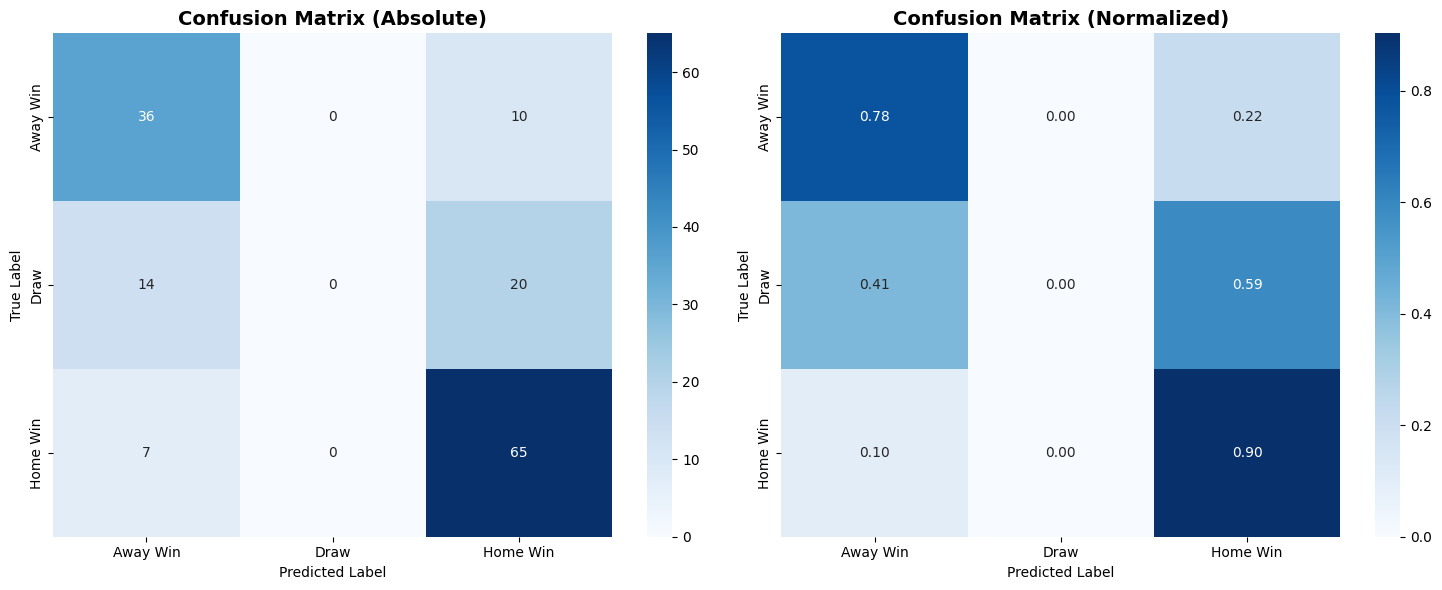


4. Feature Importance (Linear SVM Approximation):


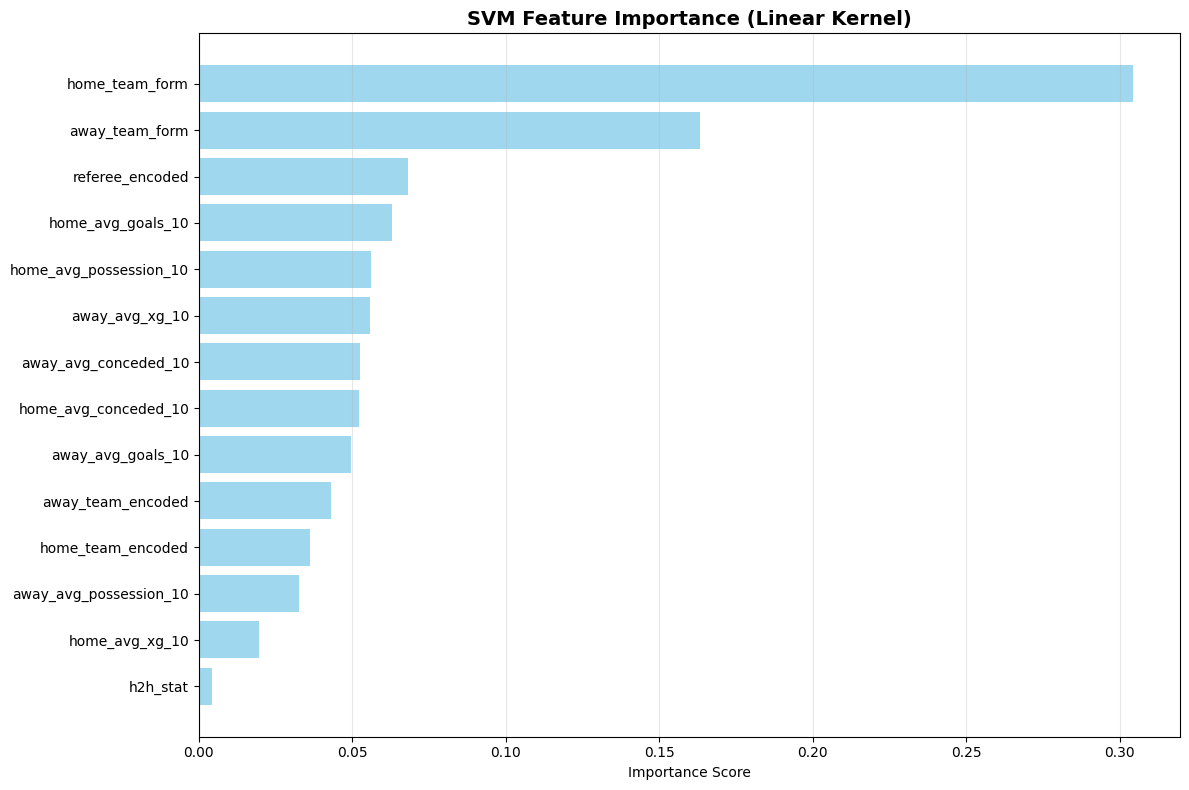

Top 5 wichtigste Features:
1. home_team_form: 0.3044
2. away_team_form: 0.1632
3. referee_encoded: 0.0682
4. home_avg_goals_10: 0.0628
5. home_avg_possession_10: 0.0561

Decision Function Statistics:
Mean absolute decision score: 1.1081

SVM MODEL SUMMARY
Best Parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Test Accuracy: 0.6645
Cross-Validation Score: 0.6496 ± 0.0204
Training Samples: 608
Test Samples: 152
Number of Features: 14


In [65]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Support Vector Machine Training")
print("="*50)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



svm_baseline = SVC(kernel='rbf', random_state=42)
svm_baseline.fit(X_train_scaled, y_train)


y_pred_baseline = svm_baseline.predict(X_test_scaled)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")


param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")


best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, y_pred_best)

print(f"\n3. Final Evaluation:")
print(f"Test Accuracy: {best_accuracy:.4f}")
print(f"Improvement: {best_accuracy - baseline_accuracy:.4f}")


cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=5)
print(f"\n5-Fold CV Scores: {cv_scores}")
print(f"CV Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

target_names = ['Away Win', 'Draw', 'Home Win']
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=target_names))


fig, axes = plt.subplots(1, 2, figsize=(15, 6))


cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_title('Confusion Matrix (Absolute)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')


cm_percent = confusion_matrix(y_test, y_pred_best, normalize='true')
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


print(f"\n4. Feature Importance (Linear SVM Approximation):")
linear_svm = SVC(kernel='linear', C=grid_search.best_params_['C'], random_state=42)
linear_svm.fit(X_train_scaled, y_train)


if hasattr(linear_svm, 'coef_'):
    feature_importance = np.abs(linear_svm.coef_).mean(axis=0)
    feature_importance = feature_importance / feature_importance.sum()
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'],
             color='skyblue', alpha=0.8)
    plt.title('SVM Feature Importance (Linear Kernel)', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("Top 5 wichtigste Features:")
    for i, (_, row) in enumerate(feature_importance_df.head().iterrows(), 1):
        print(f"{i}. {row['Feature']}: {row['Importance']:.4f}")


decision_scores = best_svm.decision_function(X_test_scaled)
print(f"\nDecision Function Statistics:")
print(f"Mean absolute decision score: {np.abs(decision_scores).mean():.4f}")


print(f"\n" + "="*60)
print(f"SVM MODEL SUMMARY")
print(f"="*60)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test Accuracy: {best_accuracy:.4f}")
print(f"Cross-Validation Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print(f"Number of Features: {X.shape[1]}")
trained_svm = best_svm
trained_scaler = scaler

Preview der Prediction Results:
          date                home_team        away_team actual_label  \
0   2022-08-06         Newcastle United  Nott'ham Forest     Home Win   
1   2022-08-06                  Everton          Chelsea     Away Win   
2   2022-08-06             Leeds United           Wolves     Home Win   
3   2022-08-07           Leicester City        Brentford         Draw   
4   2022-08-15                Liverpool   Crystal Palace         Draw   
5   2022-08-20        Tottenham Hotspur           Wolves     Home Win   
6   2022-08-21         Newcastle United  Manchester City         Draw   
7   2022-08-27                Liverpool      Bournemouth     Home Win   
8   2022-08-28  Wolverhampton Wanderers    Newcastle Utd         Draw   
9   2022-08-31                  Arsenal      Aston Villa     Home Win   
10  2022-09-18                Brentford          Arsenal     Away Win   
11  2022-10-08         Newcastle United        Brentford     Home Win   
12  2022-10-15     

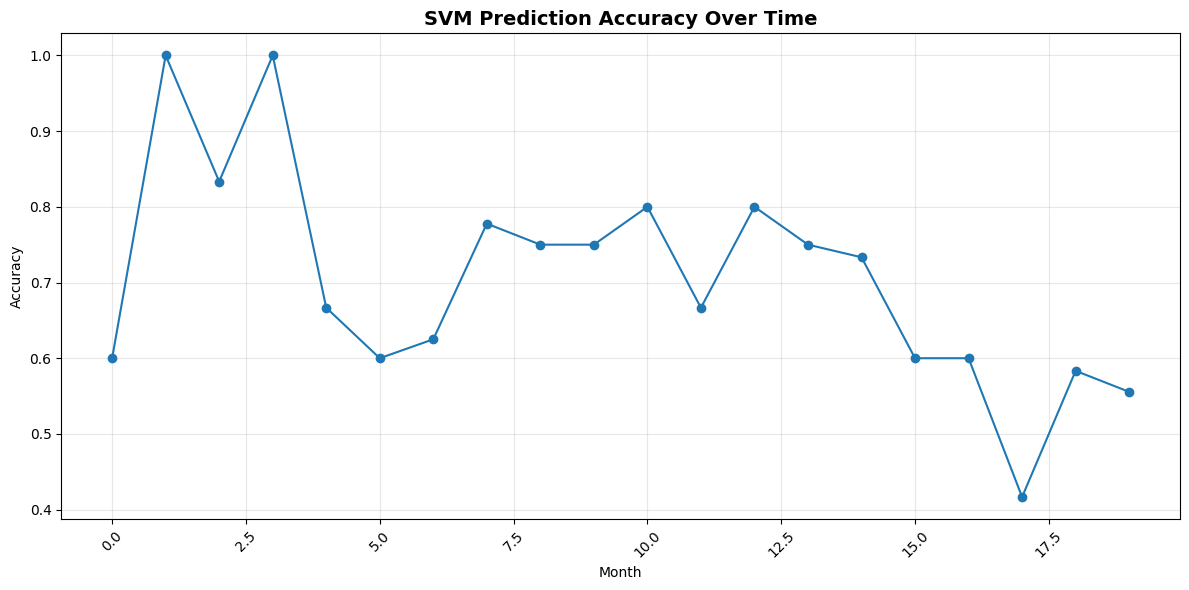


CSV Columns:
 1. date
 2. home_team
 3. away_team
 4. actual_result
 5. predicted_result
 6. actual_label
 7. predicted_label
 8. correct_prediction
 9. confidence
10. month


In [66]:

def create_prediction_results_csv(X_test, y_test, y_pred, test_indices):
    test_data = ml_ready_dataset.iloc[test_indices].copy()


    results_df = test_data[['date', 'home_team', 'away_team']].copy()


    results_df['actual_result'] = y_test.values
    results_df['predicted_result'] = y_pred


    label_map = {-1: 'Away Win', 0: 'Draw', 1: 'Home Win'}
    results_df['actual_label'] = results_df['actual_result'].map(label_map)
    results_df['predicted_label'] = results_df['predicted_result'].map(label_map)


    results_df['correct_prediction'] = (results_df['actual_result'] == results_df['predicted_result'])


    if hasattr(best_svm, 'predict_proba'):
        probabilities = best_svm.predict_proba(X_test_scaled)
        results_df['confidence'] = np.max(probabilities, axis=1)
    else:

        decision_scores = best_svm.decision_function(X_test_scaled)
        if decision_scores.ndim > 1:

            results_df['confidence'] = np.max(np.abs(decision_scores), axis=1)
        else:
            results_df['confidence'] = np.abs(decision_scores)

    return results_df


test_indices = X_test.index


prediction_results = create_prediction_results_csv(X_test, y_test, y_pred_best, test_indices)


prediction_results['date'] = pd.to_datetime(prediction_results['date']).dt.strftime('%Y-%m-%d')


prediction_results = prediction_results.sort_values('date').reset_index(drop=True)

print("Preview der Prediction Results:")
print("="*80)
print(prediction_results[['date', 'home_team', 'away_team', 'actual_label',
                         'predicted_label', 'correct_prediction', 'confidence']].head(15))


print(f"\nPrediction Statistics:")
print(f"Total Predictions: {len(prediction_results)}")
print(f"Correct Predictions: {prediction_results['correct_prediction'].sum()}")
print(f"Accuracy: {prediction_results['correct_prediction'].mean():.4f}")


print(f"\nAccuracy by Result Type:")
for result_type in [-1, 0, 1]:
    subset = prediction_results[prediction_results['actual_result'] == result_type]
    if len(subset) > 0:
        accuracy = subset['correct_prediction'].mean()
        label = {-1: 'Away Win', 0: 'Draw', 1: 'Home Win'}[result_type]
        print(f"{label}: {accuracy:.4f} ({subset['correct_prediction'].sum()}/{len(subset)})")


print(f"\nConfidence Statistics:")
print(f"Mean Confidence: {prediction_results['confidence'].mean():.4f}")
print(f"High Confidence (>0.8): {(prediction_results['confidence'] > 0.8).sum()} predictions")
print(f"Low Confidence (<0.3): {(prediction_results['confidence'] < 0.3).sum()} predictions")

print(f"\nHighest Confidence Correct Predictions:")
high_conf_correct = prediction_results[
    (prediction_results['correct_prediction']) &
    (prediction_results['confidence'] > prediction_results['confidence'].quantile(0.9))
].nlargest(5, 'confidence')

for _, row in high_conf_correct.iterrows():
    print(f"{row['date']}: {row['home_team']} vs {row['away_team']} - "
          f"Predicted: {row['predicted_label']}, Confidence: {row['confidence']:.3f}")

print(f"\nHighest Confidence Wrong Predictions:")
high_conf_wrong = prediction_results[
    (~prediction_results['correct_prediction']) &
    (prediction_results['confidence'] > prediction_results['confidence'].quantile(0.8))
].nlargest(5, 'confidence')

for _, row in high_conf_wrong.iterrows():
    print(f"{row['date']}: {row['home_team']} vs {row['away_team']} - "
          f"Predicted: {row['predicted_label']}, Actual: {row['actual_label']}, "
          f"Confidence: {row['confidence']:.3f}")


csv_filename = 'svm_prediction_results.csv'
prediction_results.to_csv(csv_filename, index=False)
print(f"\n✓ Results saved to '{csv_filename}'")

prediction_results['month'] = pd.to_datetime(prediction_results['date']).dt.to_period('M')
monthly_accuracy = prediction_results.groupby('month')['correct_prediction'].agg(['count', 'sum', 'mean'])
monthly_accuracy.columns = ['total_predictions', 'correct_predictions', 'accuracy']

print(f"\nMonthly Accuracy:")
print(monthly_accuracy.round(3))

plt.figure(figsize=(12, 6))
monthly_accuracy.reset_index()['accuracy'].plot(kind='line', marker='o')
plt.title('SVM Prediction Accuracy Over Time', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCSV Columns:")
for i, col in enumerate(prediction_results.columns, 1):
    print(f"{i:2d}. {col}")

XGBoost Model Training & Evaluation
Training Set: 608 samples
Test Set: 152 samples
XGBoost benötigt keine Feature-Skalierung
Target Labels remapped: Away Win=0, Draw=1, Home Win=2

1. Baseline XGBoost
Baseline Accuracy: 0.6645

2. Hyperparameter Tuning
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}
Best CV Score: 0.6168

3. Final Evaluation:
Test Accuracy: 0.6711
Improvement: 0.0066

5-Fold CV Scores: [0.63114754 0.59836066 0.6147541  0.59504132 0.6446281 ]
CV Mean: 0.6168 (+/- 0.0379)

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.65      0.80      0.72        46
        Draw       0.45      0.15      0.22        34
    Home Win       0.71      0.83      0.77        72

    accuracy                           0.67       152
   macro avg       0.61      0.59      0.57       152
weighted avg       0.64      0.67      0.63     

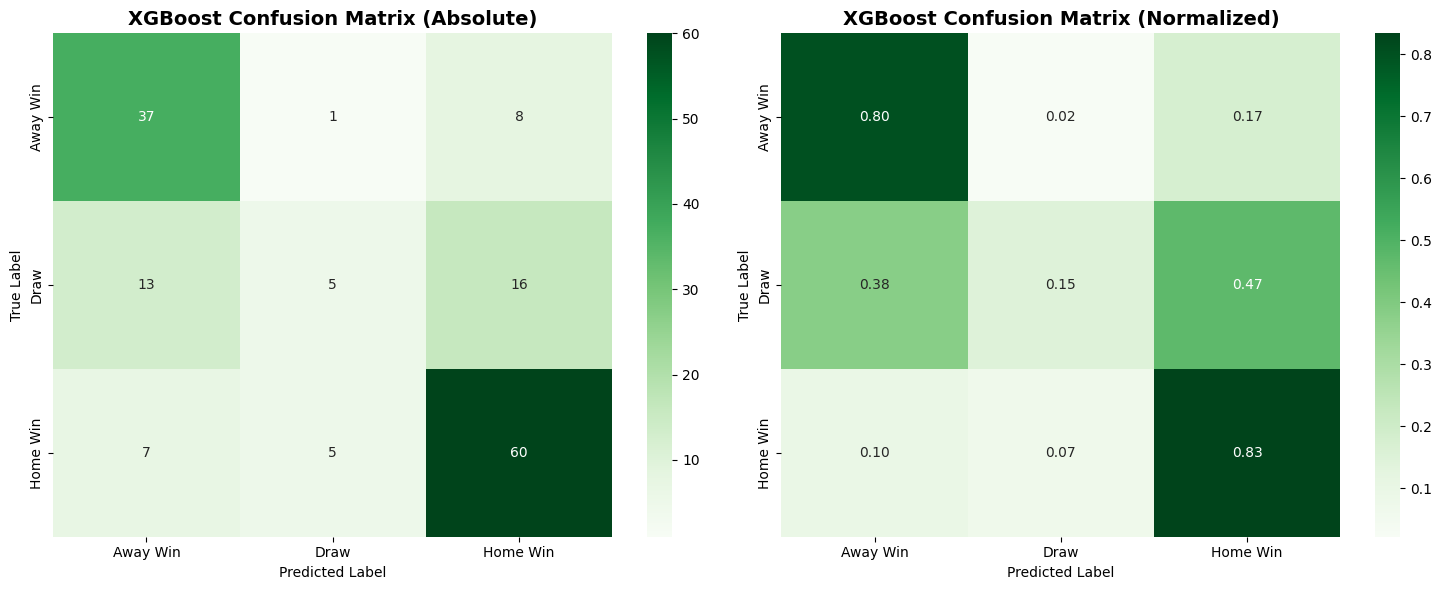

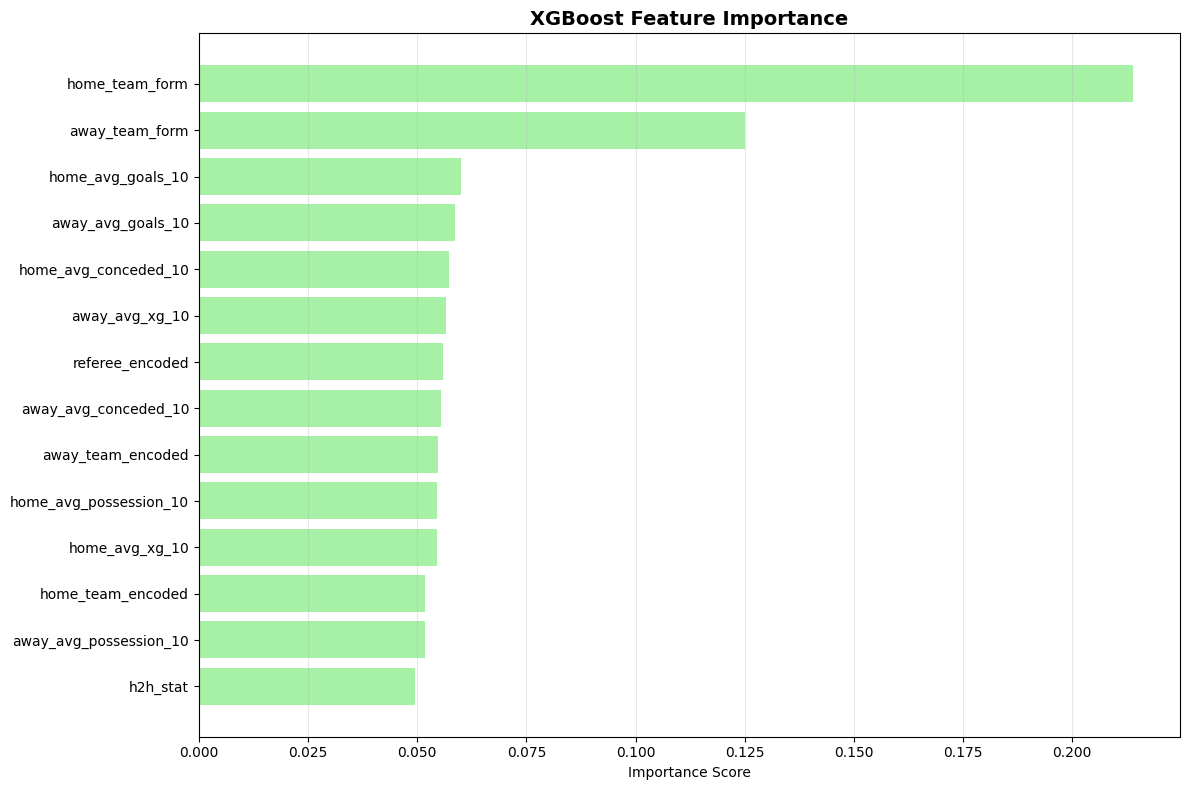

Top 10 most important Features (XGBoost):
 1. home_team_form           : 0.2140
 2. away_team_form           : 0.1250
 3. home_avg_goals_10        : 0.0601
 4. away_avg_goals_10        : 0.0587
 5. home_avg_conceded_10     : 0.0572
 6. away_avg_xg_10           : 0.0567
 7. referee_encoded          : 0.0559
 8. away_avg_conceded_10     : 0.0555
 9. away_team_encoded        : 0.0547
10. home_avg_possession_10   : 0.0546

Prediction Confidence Statistics:
Mean Confidence: 0.7426
High Confidence (>0.8): 73 predictions
Low Confidence (<0.5): 23 predictions

MODEL COMPARISON: SVM vs XGBoost
SVM Test Accuracy:      0.6645
XGBoost Test Accuracy:  0.6711
Difference:             +0.0066

SVM CV Score:           0.6496 ± 0.0204
XGBoost CV Score:       0.6168 ± 0.0190
XGBoost performs better!

XGBoost Results saved to 'xgboost_prediction_results.csv'


In [67]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("XGBoost Model Training & Evaluation")
print("="*50)



print(f"Training Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")


print(f"XGBoost benötigt keine Feature-Skalierung")

y_train_xgb = y_train.map({-1: 0, 0: 1, 1: 2})
y_test_xgb = y_test.map({-1: 0, 0: 1, 1: 2})

print(f"Target Labels remapped: Away Win=0, Draw=1, Home Win=2")


print(f"\n1. Baseline XGBoost")
xgb_baseline = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    eval_metric='mlogloss'
)
xgb_baseline.fit(X_train, y_train_xgb)


y_pred_baseline_xgb = xgb_baseline.predict(X_test)
baseline_accuracy_xgb = accuracy_score(y_test_xgb, y_pred_baseline_xgb)
print(f"Baseline Accuracy: {baseline_accuracy_xgb:.4f}")


print(f"\n2. Hyperparameter Tuning")
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}


param_grid_small = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    xgb.XGBClassifier(objective='multi:softprob', num_class=3, random_state=42, eval_metric='mlogloss'),
    param_grid_small,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train, y_train_xgb)

print(f"\nBest Parameters: {grid_search_xgb.best_params_}")
print(f"Best CV Score: {grid_search_xgb.best_score_:.4f}")


best_xgb = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
best_accuracy_xgb = accuracy_score(y_test_xgb, y_pred_best_xgb)

print(f"\n3. Final Evaluation:")
print(f"Test Accuracy: {best_accuracy_xgb:.4f}")
print(f"Improvement: {best_accuracy_xgb - baseline_accuracy_xgb:.4f}")


cv_scores_xgb = cross_val_score(best_xgb, X_train, y_train_xgb, cv=5)
print(f"\n5-Fold CV Scores: {cv_scores_xgb}")
print(f"CV Mean: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std() * 2:.4f})")

target_names = ['Away Win', 'Draw', 'Home Win']
print(f"\nClassification Report:")
print(classification_report(y_test_xgb, y_pred_best_xgb, target_names=target_names))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

cm_xgb = confusion_matrix(y_test_xgb, y_pred_best_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_title('XGBoost Confusion Matrix (Absolute)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')


cm_percent_xgb = confusion_matrix(y_test_xgb, y_pred_best_xgb, normalize='true')
sns.heatmap(cm_percent_xgb, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_title('XGBoost Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

feature_importance_xgb = best_xgb.feature_importances_
feature_importance_xgb_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance_xgb
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_xgb_df['Feature'], feature_importance_xgb_df['Importance'],
         color='lightgreen', alpha=0.8)
plt.title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("Top 10 most important Features (XGBoost):")
for i, (_, row) in enumerate(feature_importance_xgb_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:<25}: {row['Importance']:.4f}")

y_pred_proba_xgb = best_xgb.predict_proba(X_test)
prediction_confidence_xgb = np.max(y_pred_proba_xgb, axis=1)

print(f"\nPrediction Confidence Statistics:")
print(f"Mean Confidence: {prediction_confidence_xgb.mean():.4f}")
print(f"High Confidence (>0.8): {(prediction_confidence_xgb > 0.8).sum()} predictions")
print(f"Low Confidence (<0.5): {(prediction_confidence_xgb < 0.5).sum()} predictions")

print(f"\n" + "="*80)
print(f"MODEL COMPARISON: SVM vs XGBoost")
print(f"="*80)
print(f"SVM Test Accuracy:      {best_accuracy:.4f}")
print(f"XGBoost Test Accuracy:  {best_accuracy_xgb:.4f}")
print(f"Difference:             {best_accuracy_xgb - best_accuracy:+.4f}")
print(f"")
print(f"SVM CV Score:           {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"XGBoost CV Score:       {cv_scores_xgb.mean():.4f} ± {cv_scores_xgb.std():.4f}")

if best_accuracy_xgb > best_accuracy:
    print(f"XGBoost performs better!")
elif best_accuracy > best_accuracy_xgb:
    print(f"SVM performs better!")
else:
    print(f"Both models perform equally!")

y_pred_best_xgb_original = pd.Series(y_pred_best_xgb).map({0: -1, 1: 0, 2: 1})
y_test_original = y_test

prediction_results_xgb = create_prediction_results_csv(X_test, y_test_original, y_pred_best_xgb_original, test_indices)

prediction_results_xgb['confidence'] = prediction_confidence_xgb

csv_filename_xgb = 'xgboost_prediction_results.csv'
prediction_results_xgb.to_csv(csv_filename_xgb, index=False)
print(f"\nXGBoost Results saved to '{csv_filename_xgb}'")


trained_xgb = best_xgb